In [3]:

import datetime
import numpy as np
import cv2
from itertools import cycle
import pickle
import pathlib
import math
import tqdm
import scipy.io
from matplotlib import pyplot as plt
import scipy.io
import h5py
import re
from lxml import etree as ET
import scipy.signal as sig
import pandas as pd
from scipy.stats import kde
from BlockSync_current import BlockSync
import UtilityFunctions_newOE as uf
from scipy import signal
import bokeh
import seaborn as sns
from matplotlib import rcParams
%matplotlib inline
plt.style.use('default')
rcParams['pdf.fonttype'] = 42  # Ensure fonts are embedded and editable
rcParams['ps.fonttype'] = 42  # Ensure compatibility with vector outputs


def bokeh_plotter(data_list, x_axis_list=None, label_list=None,
                  plot_name='default',
                  x_axis_label='X', y_axis_label='Y',
                  peaks=None, peaks_list=False, export_path=False):
    """Generates an interactive Bokeh plot for the given data vector.
    Args:
        data_list (list or array): The data to be plotted.
        label_list (list of str): The labels of the data vectors
        plot_name (str, optional): The title of the plot. Defaults to 'default'.
        x_axis (str, optional): The label for the x-axis. Defaults to 'X'.
        y_axis (str, optional): The label for the y-axis. Defaults to 'Y'.
        peaks (list or array, optional): Indices of peaks to highlight on the plot. Defaults to None.
        export_path (False or str): when set to str, will output the resulting html fig
    """
    color_cycle = cycle(bokeh.palettes.Category10_10)
    fig = bokeh.plotting.figure(title=f'bokeh explorer: {plot_name}',
                                x_axis_label=x_axis_label,
                                y_axis_label=y_axis_label,
                                plot_width=1500,
                                plot_height=700)

    for i, data_vector in enumerate(data_list):

        color = next(color_cycle)

        if x_axis_list is None:
            x_axis = range(len(data_vector))
        elif len(x_axis_list) == len(data_list):
            print('x_axis manually set')
            x_axis = x_axis_list[i]
        else:
            raise Exception(
                'problem with x_axis_list input - should be either None, or a list with the same length as data_list')
        if label_list is None:
            fig.line(x_axis, data_vector, line_color=color, legend_label=f"Line {i + 1}")
        elif len(label_list) == len(data_list):
            fig.line(range(len(data_vector)), data_vector, line_color=color, legend_label=f"{label_list[i]}")
        if peaks is not None and peaks_list is True:
            fig.circle(peaks[i], data_vector[peaks[i]], size=10, color=color)

    if peaks is not None and peaks_list is False:
        fig.circle(peaks, data_vector[peaks], size=10, color='red')

    if export_path is not False:
        print(f'exporting to {export_path}')
        bokeh.io.output.output_file(filename=str(export_path / f'{plot_name}.html'), title=f'{plot_name}')
    bokeh.plotting.show(fig)


def load_eye_data_2d_w_rotation_matrix(block):
    """
    This function checks if the eye dataframes and rotation dict object exist, then imports them
    :param block: The current blocksync class with verifiec re/le dfs
    :return: None
    """
    try:
        block.left_eye_data = pd.read_csv(block.analysis_path / 'left_eye_data.csv', index_col=0, engine='python')
        block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data.csv', index_col=0, engine='python')
    except FileNotFoundError:
        print('eye_data files not found, run the pipeline!')
        return

    try:
        with open(block.analysis_path / 'rotate_eye_data_params.pkl', 'rb') as file:
            rotation_dict = pickle.load(file)
            block.left_rotation_matrix = rotation_dict['left_rotation_matrix']
            block.right_rotation_matrix = rotation_dict['right_rotation_matrix']
            block.left_rotation_angle = rotation_dict['left_rotation_angle']
            block.right_rotation_angle = rotation_dict['right_rotation_angle']
    except FileNotFoundError:
        print('No rotation matrix file, create it')


def create_saccade_events_df(eye_data_df, speed_threshold, bokeh_verify_threshold=False, magnitude_calib=1,
                             speed_profile=True):
    """
    Detects saccade events in eye tracking data and computes relevant metrics.

    Parameters:
    - eye_data_df (pd.DataFrame): Input DataFrame containing eye tracking data.
    - speed_threshold (float): Threshold for saccade detection based on speed.

    Returns:
    - df (pd.DataFrame): Modified input DataFrame with added columns for speed and saccade detection.
    - saccade_events_df (pd.DataFrame): DataFrame containing information about detected saccade events.

    Steps:
    1. Calculate speed components ('speed_x', 'speed_y') based on differences in 'center_x' and 'center_y'.
    2. Compute the magnitude of the velocity vector ('speed_r').
    3. Create a binary column ('is_saccade') indicating saccade events based on the speed threshold.
    4. Determine saccade onset and offset indices and timestamps.
    5. Create a DataFrame ('saccade_events_df') with columns:
        - 'saccade_start_ind': Indices of saccade onset.
        - 'saccade_start_timestamp': Timestamps corresponding to saccade onset.
        - 'saccade_end_ind': Indices of saccade offset.
        - 'saccade_end_timestamp': Timestamps corresponding to saccade offset.
        - 'length': Duration of each saccade event.
    6. Calculate distance traveled and angles for each saccade event.
    7. Append additional columns to 'saccade_events_df':
        - 'magnitude': Magnitude of the distance traveled during each saccade.
        - 'angle': Angle of the saccade vector in degrees.
        - 'initial_x', 'initial_y': Initial coordinates of the saccade.
        - 'end_x', 'end_y': End coordinates of the saccade.

    Note: The original 'eye_data_df' is not modified; modified data is returned as 'df'.
    """
    df = eye_data_df
    df['speed_x'] = df['center_x'].diff()  # Difference between consecutive 'center_x' values
    df['speed_y'] = df['center_y'].diff()  # Difference between consecutive 'center_y' values

    # Step 2: Calculate magnitude of the velocity vector (R vector speed)
    df['speed_r'] = (df['speed_x'] ** 2 + df['speed_y'] ** 2) ** 0.5

    # Create a column for saccade detection
    df['is_saccade'] = df['speed_r'] > speed_threshold

    # create a saccade_on_off indicator where 1 is rising edge and -1 is falling edge by subtracting a shifted binary mask
    saccade_on_off = df.is_saccade.astype(int) - df.is_saccade.shift(periods=1, fill_value=False).astype(int)
    saccade_on_inds = np.where(saccade_on_off == 1)[
                          0] - 1  # notice the manual shift here, chosen to include the first (sometimes slower) eye frame, just before saccade threshold crossing
    saccade_on_ms = df['ms_axis'].iloc[saccade_on_inds]
    saccade_on_timestamps = df['OE_timestamp'].iloc[saccade_on_inds]
    saccade_off_inds = np.where(saccade_on_off == -1)[0]
    saccade_off_timestamps = df['OE_timestamp'].iloc[saccade_off_inds]
    saccade_off_ms = df['ms_axis'].iloc[saccade_off_inds]

    saccade_dict = {'saccade_start_ind': saccade_on_inds,
                    'saccade_start_timestamp': saccade_on_timestamps.values,
                    'saccade_end_ind': saccade_off_inds,
                    'saccade_end_timestamp': saccade_off_timestamps.values,
                    'saccade_on_ms': saccade_on_ms.values,
                    'saccade_off_ms': saccade_off_ms.values}

    saccade_events_df = pd.DataFrame.from_dict(saccade_dict)
    saccade_events_df['length'] = saccade_events_df['saccade_end_ind'] - saccade_events_df['saccade_start_ind']
    # Drop columns used for intermediate steps
    df = df.drop(['is_saccade'], axis=1)

    distances = []
    angles = []
    speed_list = []
    speed_list_calib = []
    diameter_list = []
    for index, row in tqdm.tqdm(saccade_events_df.iterrows()):
        saccade_samples = df.loc[(df['OE_timestamp'] >= row['saccade_start_timestamp']) &
                                 (df['OE_timestamp'] <= row['saccade_end_timestamp'])]
        distance_traveled = saccade_samples['speed_r'].sum()
        if speed_profile:
            saccade_speed_profile = saccade_samples['speed_r'].values
            saccade_calib_speed_profile = saccade_samples['speed_r'].values * magnitude_calib
            speed_list.append(saccade_speed_profile)
            speed_list_calib.append(saccade_calib_speed_profile)
        saccade_diameter_profile = saccade_samples['pupil_diameter'].values
        diameter_list.append(saccade_diameter_profile)
        # Calculate angle from initial position to endpoint
        initial_position = saccade_samples.iloc[0][['center_x', 'center_y']]
        endpoint = saccade_samples.iloc[-1][['center_x', 'center_y']]
        overall_angle = np.arctan2(endpoint['center_y'] - initial_position['center_y'],
                                   endpoint['center_x'] - initial_position['center_x'])

        angles.append(overall_angle)
        distances.append(distance_traveled)

    saccade_events_df['magnitude_raw'] = np.array(distances)
    saccade_events_df['magnitude'] = np.array(distances) * magnitude_calib
    saccade_events_df['angle'] = np.where(np.isnan(angles), angles, np.rad2deg(
        angles) % 360)  # Convert radians to degrees and ensure result is in [0, 360)
    start_ts = saccade_events_df['saccade_start_timestamp'].values
    end_ts = saccade_events_df['saccade_end_timestamp'].values
    saccade_start_df = df[df['OE_timestamp'].isin(start_ts)]
    saccade_end_df = df[df['OE_timestamp'].isin(end_ts)]
    start_x_coord = saccade_start_df['center_x']
    start_y_coord = saccade_start_df['center_y']
    end_x_coord = saccade_end_df['center_x']
    end_y_coord = saccade_end_df['center_y']
    saccade_events_df['initial_x'] = start_x_coord.values
    saccade_events_df['initial_y'] = start_y_coord.values
    saccade_events_df['end_x'] = end_x_coord.values
    saccade_events_df['end_y'] = end_y_coord.values
    saccade_events_df['calib_dx'] = (saccade_events_df['end_x'].values - saccade_events_df[
        'initial_x'].values) * magnitude_calib
    saccade_events_df['calib_dy'] = (saccade_events_df['end_y'].values - saccade_events_df[
        'initial_y'].values) * magnitude_calib
    if speed_profile:
        saccade_events_df['speed_profile'] = speed_list
        saccade_events_df['speed_profile_calib'] = speed_list_calib
    saccade_events_df['diameter_profile'] = diameter_list
    if bokeh_verify_threshold:
        bokeh_plotter(data_list=[df.speed_r], label_list=['Pupil Velocity'], peaks=saccade_on_inds)

    return df, saccade_events_df


In [1]:
import pandas as pd

def read_behavior_state(block):
    """
    Reads the behavior_state CSV file from the block's analysis folder and assigns it to the block object.

    Args:
        block (BlockSync): The block object containing metadata about the analysis folder.

    Returns:
        pd.DataFrame: The loaded behavior state dataframe.
    """
    try:
        # Construct the path to the CSV file
        csv_path = block.analysis_path / f"block_{block.block_num}_behavior_state.csv"
        
        if not csv_path.exists():
            raise FileNotFoundError(f"No behavior_state file found at {csv_path}")
        
        # Read the CSV into a DataFrame
        behavior_state_df = pd.read_csv(csv_path)
        
        # Assign it to the block object for easy access
        block.behavior_state = behavior_state_df
        print(f"Behavior state successfully loaded from {csv_path}")
        
        return behavior_state_df
    
    except Exception as e:
        print(f"Error reading behavior state: {e}")
        return None

def create_distance_plot(distances, top_dist_to_show=500):
    # Create cumulative distribution plot
    sns.set(style="whitegrid")
    fig, axs = plt.subplots(2, figsize=(6, 6), dpi=150)
    
    axs[0].set_title('Cumulative Euclidean Distances for Camera Jitter', fontsize=15)
    axs[0].set_ylabel('Cumulative \n % of Frames')
    axs[0].set_xlim(0, top_dist_to_show)
    axs[0].grid(False)
    
    # Create histogram and cumulative distribution
    sns.kdeplot(distances, cumulative=True, label='Left Eye', ax=axs[0], linewidth=4, c='black')
    
    axs[1].hist(distances, bins=np.linspace(0, top_dist_to_show, 20), log=False, color='black')

    # Set title and labels
    title = 'Image displacement histogram'
    axs[1].set_title(title, fontsize=15)
    axs[1].set_xlabel('Euclidean Displacement [$\mu$m]', fontsize=15)
    axs[1].set_xscale('linear')
    axs[1].set_yscale('linear')
    axs[1].set_ylabel('Frame count', fontsize=15)

    # Adjust tick label sizes
    axs[1].tick_params(axis='x', which='major', labelsize=15)

    # Set white background and black text
    axs[1].set_facecolor('white')
    axs[1].title.set_color('black')
    axs[1].xaxis.label.set_color('black')
    axs[1].yaxis.label.set_color('black')
    axs[1].tick_params(colors='black')
    axs[1].grid(False)

    plt.tight_layout()

    return fig, axs
def add_intermediate_elements(input_vector, gap_to_bridge):
    # Step 1: Calculate differences between each element
    differences = np.diff(input_vector)

    # Step 2: Add intervening elements based on the diff_threshold
    output_vector = [input_vector[0]]
    for i, diff in enumerate(differences):
        if diff < gap_to_bridge:
            # Add intervening elements
            output_vector.extend(range(input_vector[i] + 1, input_vector[i + 1]))

        # Add the next element from the original vector
        output_vector.append(input_vector[i + 1])

    return np.sort(np.unique(output_vector))

def find_jittery_frames(block, eye, max_distance, diff_threshold, gap_to_bridge=6):
    
    #input checks
    if eye not in ['left', 'right']:
        print(f'eye can only be left/right, your input: {eye}')
        return None
    # eye setup
    if eye == 'left':
        jitter_dict = block.le_jitter_dict
        eye_frame_col = 'L_eye_frame'
    elif eye == 'right':
        jitter_dict = block.re_jitter_dict
        eye_frame_col = 'R_eye_frame'
    
    df_dict = {'left':block.le_df,
               'right':block.re_df}
    
    df = pd.DataFrame.from_dict(jitter_dict)
    indices_of_highest_drift = df.query("top_correlation_dist > @max_distance").index.values
    diff_vec = np.diff(df['top_correlation_dist'].values)
    diff_peaks_indices = np.where(diff_vec > diff_threshold)[0]
    video_indices = np.concatenate((diff_peaks_indices, indices_of_highest_drift))
    print(f'the diff based jitter frame exclusion gives: {np.shape(diff_peaks_indices)}')
    print(f'the threshold based jitter frame exclusion gives: {np.shape(indices_of_highest_drift)}')
    
    # creates a bridged version of the overly jittery frames (to contend with single frame outliers)
    video_indices = add_intermediate_elements(video_indices, gap_to_bridge=gap_to_bridge)
    # This is the input you should give to the BlockSync.remove_eye_datapoints function (which already maps it to the df) 
    
    
    # translates the video indices to le/re dataframe rows
    df_indices_to_remove = df_dict[eye].loc[df_dict[eye][eye_frame_col].isin(video_indices)].index.values
    
    return df_indices_to_remove, video_indices

def bokeh_plotter(data_list, label_list,
                  plot_name='default',
                  x_axis='X', y_axis='Y',
                  peaks=None, peaks_list=False, export_path=False):
    """Generates an interactive Bokeh plot for the given data vector.
    Args:
        data_list (list or array): The data to be plotted.
        label_list (list of str): The labels of the data vectors
        plot_name (str, optional): The title of the plot. Defaults to 'default'.
        x_axis (str, optional): The label for the x-axis. Defaults to 'X'.
        y_axis (str, optional): The label for the y-axis. Defaults to 'Y'.
        peaks (list or array, optional): Indices of peaks to highlight on the plot. Defaults to None.
        export_path (False or str): when set to str, will output the resulting html fig
    """
    color_cycle = cycle(bokeh.palettes.Category10_10)
    fig = bokeh.plotting.figure(title=f'bokeh explorer: {plot_name}',
                                x_axis_label=x_axis,
                                y_axis_label=y_axis,
                                plot_width=1500,
                                plot_height=700)

    for i, vec in enumerate(range(len(data_list))):
        color = next(color_cycle)
        data_vector = data_list[vec]
        if label_list is None:
            fig.line(range(len(data_vector)), data_vector, line_color=color, legend_label=f"Line {len(fig.renderers)}")
        elif len(label_list) == len(data_list):
            fig.line(range(len(data_vector)), data_vector, line_color=color, legend_label=f"{label_list[i]}")
        if peaks is not None and peaks_list is True:
            fig.circle(peaks[i], data_vector[peaks[i]], size=10, color=color)

    if peaks is not None and peaks_list is False:
        fig.circle(peaks, data_vector[peaks], size=10, color='red')

    if export_path is not False:
        print(f'exporting to {export_path}')
        bokeh.io.output.output_file(filename=str(export_path / f'{plot_name}.html'), title=f'{plot_name}')
    bokeh.plotting.show(fig)
    
def play_video_with_ellipses_rotation(block, eye, path_to_video=False, xflip=False, transformation_matrix=None, phi_in_radians=False):
    if eye == 'left':
        video_path = block.le_videos[0]
        ellipse_dataframe = block.left_eye_data
    elif eye == 'right':
        video_path = block.re_videos[0]
        ellipse_dataframe = block.right_eye_data
    else:
        raise ValueError(f"eye can only be 'left' or 'right'")
    
    if video_path is not False:
        video_path = path_to_video

    # Open the video file
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error opening video file.")
        return

    # Loop through each frame
    while True:
        # Read a frame from the video
        ret, frame = cap.read()
    
        if not ret:
            # Break the loop if the video is finished
            break
        
        # Optionally flip the frame along the x-axis
        if xflip:
            frame = cv2.flip(frame, 1)

        # Apply transformation matrix if provided
        if transformation_matrix is not None:
            frame = cv2.warpAffine(frame, transformation_matrix, (frame.shape[1], frame.shape[0]))

        # Get the corresponding ellipse data for the current frame
        current_frame_num = int(cap.get(cv2.CAP_PROP_POS_FRAMES)) - 1
        try:
            current_frame_data = ellipse_dataframe.iloc[ellipse_dataframe.query('eye_frame == @current_frame_num').index[0]]
        except IndexError:
            continue

        # Extract ellipse parameters
        if transformation_matrix is not None:
            try:
                center_x = int(current_frame_data['center_x'])
                center_y = int(current_frame_data['center_y'])
                width = int(current_frame_data['width'])
                height = int(current_frame_data['height'])
                if phi_in_radians:
                    phi = np.deg2rad(float(current_frame_data['phi']))
                else:
                    phi = float(current_frame_data['phi'])
                
                # Draw the ellipse on the frame
                cv2.ellipse(frame, (center_x, center_y), (width, height), phi, 0, 360, (0, 255, 0), 2)
                
                # Add text to the frame
                text = f'ellipse angle: {phi}'
                cv2.putText(frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
        
                
                # Display the frame
                cv2.imshow('Video with Ellipses', frame)
            
                # Check for the 'q' key to quit
                if cv2.waitKey(25) & 0xFF == ord('q'):
                    break
            except ValueError:
                continue
        else:
            try:
                center_x = int(current_frame_data['center_x'])
                center_y = int(current_frame_data['center_y'])
                width = int(current_frame_data['width'])
                height = int(current_frame_data['height'])
                if phi_in_radians:
                    phi = np.deg2rad(float(current_frame_data['phi']))
                else:
                    phi = float(current_frame_data['phi'])
        
                # Draw the ellipse on the frame
                cv2.ellipse(frame, (center_x, center_y), (width, height), phi, 0, 360, (0, 255, 0), 2)
                
                # Add text to the frame
                text = f'ellipse angle: {phi}'
                cv2.putText(frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
                
                # Display the frame
                cv2.imshow('Video with Ellipses', frame)
            
                # Check for the 'q' key to quit
                if cv2.waitKey(25) & 0xFF == ord('q'):
                    break
            except ValueError:
                continue

    # Release video capture object and close the window
    cap.release()
    cv2.destroyAllWindows()
    
def play_video_with_ellipses_rotation_plus_major_axis(block, eye, path_to_video=False, xflip=False, transformation_matrix=None):
    if eye == 'left':
        video_path = block.le_videos[0]
        ellipse_dataframe = block.left_eye_data
    elif eye == 'right':
        video_path = block.re_videos[0]
        ellipse_dataframe = block.right_eye_data
    else:
        raise ValueError(f"eye can only be 'left' or 'right'")
    
    if video_path is not False:
        video_path = path_to_video

    # Open the video file
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error opening video file.")
        return

    # Loop through each frame
    while True:
        # Read a frame from the video
        ret, frame = cap.read()
    
        if not ret:
            # Break the loop if the video is finished
            break
        
        # Optionally flip the frame along the x-axis
        if xflip:
            frame = cv2.flip(frame, 1)

        # Apply transformation matrix if provided
        if transformation_matrix is not None:
            frame = cv2.warpAffine(frame, transformation_matrix, (frame.shape[1], frame.shape[0]))

        # Get the corresponding ellipse data for the current frame
        current_frame_num = int(cap.get(cv2.CAP_PROP_POS_FRAMES)) - 1
        try:
            current_frame_data = ellipse_dataframe.iloc[ellipse_dataframe.query('eye_frame == @current_frame_num').index[0]]
        except IndexError:
            continue

        # Extract ellipse parameters
        try:
            center_x = int(current_frame_data['center_x'])
            center_y = int(current_frame_data['center_y'])
            width = int(current_frame_data['major_ax'])
            height = int(current_frame_data['minor_ax'])
            phi = np.deg2rad(float(current_frame_data['phi']))  # Convert angle to radians
            
            # Draw the ellipse on the frame
            cv2.ellipse(frame, (center_x, center_y), (width, height), phi, 0, 360, (0, 255, 0), 2)
            
            # Calculate endpoints of major axis
            axis_length = max(width, height) / 2
            sin_phi = np.sin(phi)
            cos_phi = np.cos(phi)
            x1 = int(center_x + axis_length * cos_phi)
            y1 = int(center_y + axis_length * sin_phi)
            x2 = int(center_x - axis_length * cos_phi)
            y2 = int(center_y - axis_length * sin_phi)
            
            # Draw major axis
            cv2.line(frame, (x1, y1), (x2, y2), (0, 0, 255), 2)
            
            # Add text to the frame
            text = f'ellipse angle: {np.rad2deg(phi)}'
            cv2.putText(frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
            
            # Display the frame
            cv2.imshow('Video with Ellipses', frame)
        
            # Check for the 'q' key to quit
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break
        except ValueError:
            continue

    # Release video capture object and close the window
    cap.release()
    cv2.destroyAllWindows()
    
def get_frame_count(video_path):
        """
        Get the number of frames for the video in the specified path using OpenCV.
    
        Parameters:
            video_path (str): Path to the video file.
    
        Returns:
            int: Number of frames in the video.
        """
        
        # Open the video file
        cap = cv2.VideoCapture(video_path)
    
        # Check if the video file is opened successfully
        if not cap.isOpened():
            print("Error: Could not open the video file.")
            return -1
    
        # Get the total number of frames in the video
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
        # Release the VideoCapture object
        cap.release()
    
        return frame_count


# Block Instantiation

In [4]:

# define a single block to synchronize and finally export l/r_eye_data csv files:
# this step creates block_collection - a list of BlockSync objects of interest

bad_blocks = [6] # 
experiment_path = pathlib.Path(r"Z:\Nimrod\experiments")
#animal = 'PV_62' || block_numbers = [23,24,25,26,27]
#animal = 'PV_126' || block_numbers = [7,8,9,10,11,12,13,14] 
animal = 'PV_24'  
block_numbers = [12]
block_collection = uf.block_generator(block_numbers=block_numbers,
                                      experiment_path=experiment_path,
                                      animal=animal,
                                      bad_blocks=bad_blocks,regev=False)
# create a block_dict object for ease of access:
block_dict = {}
for b in block_collection:
    block_dict[str(b.block_num)] = b
block = block_collection[0]

instantiated block number 012 at Path: Z:\Nimrod\experiments\PV_24\2021_12_27\block_012, new OE version
Found the sample rate for block 012 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 012
got it!


In [5]:
for block in block_collection:
    block.parse_open_ephys_events()
    block.get_eye_brightness_vectors()
    block.synchronize_block()
    block.create_eye_brightness_df(threshold_value=20)

    # if the code fails here, go to manual synchronization
    block.import_manual_sync_df()
    block.read_dlc_data()
    block.calibrate_pixel_size(10)
    load_eye_data_2d_w_rotation_matrix(block) #should be integrated again... later
    
    # calibrate pupil diameter:
    if 'pupil_diameter' not in block.left_eye_data.columns:
        block.left_eye_data['pupil_diameter_pixels'] = block.left_eye_data.major_ax * 2 * np.pi
        block.right_eye_data['pupil_diameter_pixels'] = block.right_eye_data.major_ax * 2 * np.pi
        block.left_eye_data['pupil_diameter'] = block.left_eye_data['pupil_diameter_pixels'] * block.L_pix_size
        block.right_eye_data['pupil_diameter'] = block.right_eye_data['pupil_diameter_pixels'] * block.R_pix_size

running parse_open_ephys_events...
block 012 has a parsed events file, reading...
Getting eye brightness values for block 012...
Found an existing file!
Eye brightness vectors generation complete.
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
eye dataframes loaded from analysis folder
got the calibration values from the analysis folder


In [31]:
# try and load the behavior state_df:
for block in block_collection:
    read_behavior_state(block)
    

Behavior state successfully loaded from Z:\Nimrod\experiments\PV_126\2024_07_18\block_007\analysis\block_007_behavior_state.csv
Behavior state successfully loaded from Z:\Nimrod\experiments\PV_126\2024_07_18\block_008\analysis\block_008_behavior_state.csv
Behavior state successfully loaded from Z:\Nimrod\experiments\PV_126\2024_07_18\block_009\analysis\block_009_behavior_state.csv
Behavior state successfully loaded from Z:\Nimrod\experiments\PV_126\2024_07_18\block_010\analysis\block_010_behavior_state.csv
Behavior state successfully loaded from Z:\Nimrod\experiments\PV_126\2024_08_13\block_011\analysis\block_011_behavior_state.csv
Behavior state successfully loaded from Z:\Nimrod\experiments\PV_126\2024_08_13\block_012\analysis\block_012_behavior_state.csv
Behavior state successfully loaded from Z:\Nimrod\experiments\PV_126\2024_08_13\block_013\analysis\block_013_behavior_state.csv
Behavior state successfully loaded from Z:\Nimrod\experiments\PV_126\2024_08_13\block_014\analysis\block

In [127]:
block_dict.keys()

dict_keys(['023', '024', '025', '026', '027'])

In [128]:
block = block_dict['023']

In [9]:
for block in block_collection:
    block.block_get_lizard_movement()
#block.block_get_lizard_movement()

path to mat file is Z:\Nimrod\experiments\PV_24\2021_12_27\block_012\oe_files\PV24_27_12_21_EE12_2021-12-27_11-36-41\Record Node 101\analysis\Animal=PV_24,recNames=Block0012\lizMov.mat


KeyError: "Unable to open object (object 't_static_ms' doesn't exist)"

In [131]:
# Over here is a multi-block behavior annotation cell which only gets one threshold and goes through the whole block_collection to annotate state
def rolling_window_analysis(df, window_size=1000, step_size=1000, method='clip', cap_value=99):
    """
    Perform a rolling window analysis on the movAll column of the input dataframe with outlier handling.

    Args:
        df (pd.DataFrame): Input dataframe with 't_mov_ms' (timestamps in ms) and 'movAll' (magnitudes).
        window_size (int): Size of the rolling window in milliseconds (default 10,000 ms).
        step_size (int): Step size for the rolling window in milliseconds (default 1,000 ms).
        method (str): Outlier handling method ('percentile', 'zscore', or 'clip').
        cap_value (float): Percentile or z-score threshold for outlier handling.

    Returns:
        pd.DataFrame: A dataframe containing the start time of each window and the adjusted average movAll value.
    """
    # Ensure the dataframe is sorted by time
    df = df.sort_values('t_mov_ms').reset_index(drop=True)

    # Handle outliers
    if method == 'percentile':
        lower_bound = np.percentile(df['movAll'], 100 - cap_value)
        upper_bound = np.percentile(df['movAll'], cap_value)
        df['movAll'] = np.clip(df['movAll'], lower_bound, upper_bound)
    elif method == 'zscore':
        mean = df['movAll'].mean()
        std = df['movAll'].std()
        z_threshold = cap_value
        df['movAll'] = np.clip(df['movAll'], mean - z_threshold * std, mean + z_threshold * std)
    elif method == 'clip':
        max_clip_value = cap_value  # Absolute clip value
        df['movAll'] = np.clip(df['movAll'], -max_clip_value, max_clip_value)
    else:
        raise ValueError("Invalid method. Choose from 'percentile', 'zscore', or 'clip'.")

    # Get the range of timestamps
    t_min = df['t_mov_ms'].min()
    t_max = df['t_mov_ms'].max()

    # Create the rolling window start times
    window_starts = np.arange(t_min, t_max + step_size, step_size)

    # Initialize results
    results = {'window_start': [], 'average_movAll': []}

    for start in tqdm.tqdm(window_starts):
        end = start + window_size
        window_data = df[(df['t_mov_ms'] >= start) & (df['t_mov_ms'] < end)]
        avg_movAll = window_data['movAll'].mean() if not window_data.empty else 0
        results['window_start'].append(start)
        results['average_movAll'].append(avg_movAll)

    return pd.DataFrame(results)


for block in block_collection:
    df = rolling_window_analysis(block.liz_mov_df,2000,1000)
    # Define the threshold manually
    threshold = 0.5
    
    # Classify behavior based on threshold
    df['behavior'] = df['average_movAll'].apply(lambda x: 'active' if x > threshold else 'quiet')
    
    def create_behavior_df(df):
        """
        Transform the annotated dataframe into a compact behavioral dataframe.
        
        Args:
            df (pd.DataFrame): Dataframe with 'window_start' and 'behavior' columns.
    
        Returns:
            pd.DataFrame: Compact behavioral dataframe with 'start_time', 'end_time', and 'annotation'.
        """
        behavior_df = []
        current_behavior = df['behavior'].iloc[0]
        start_time = df['window_start'].iloc[0]
    
        for i in range(1, len(df)):
            if df['behavior'].iloc[i] != current_behavior:
                end_time = df['window_start'].iloc[i]
                behavior_df.append({
                    'start_time': start_time,
                    'end_time': end_time,
                    'annotation': current_behavior
                })
                current_behavior = df['behavior'].iloc[i]
                start_time = df['window_start'].iloc[i]
        
        end_time = df['window_start'].iloc[-1] + 1000
        behavior_df.append({
            'start_time': start_time,
            'end_time': end_time,
            'annotation': current_behavior
        })
        return pd.DataFrame(behavior_df)
    
    # Create the behavioral dataframe
    behavior_df = create_behavior_df(df)
    
    # Save to block and export to CSV
    block.behavior_state = behavior_df
    csv_path = block.analysis_path / f"block_{block.block_num}_behavior_state.csv"
    behavior_df.to_csv(csv_path, index=False)
    print(f"Behavior state saved to {csv_path}")

 13%|█▎        | 205/1630 [00:00<00:00, 2035.86it/s]

Behavior state saved to Z:\Nimrod\experiments\PV_62\2023_04_27\block_023\analysis\block_023_behavior_state.csv


 13%|█▎        | 205/1639 [00:00<00:00, 2032.50it/s]

Behavior state saved to Z:\Nimrod\experiments\PV_62\2023_04_27\block_024\analysis\block_024_behavior_state.csv


 18%|█▊        | 320/1800 [00:00<00:00, 1691.28it/s]

Behavior state saved to Z:\Nimrod\experiments\PV_62\2023_04_27\block_025\analysis\block_025_behavior_state.csv


 13%|█▎        | 202/1547 [00:00<00:00, 2011.61it/s]

Behavior state saved to Z:\Nimrod\experiments\PV_62\2023_04_27\block_026\analysis\block_026_behavior_state.csv


100%|██████████| 1547/1547 [00:00<00:00, 1896.12it/s]

Behavior state saved to Z:\Nimrod\experiments\PV_62\2023_04_27\block_027\analysis\block_027_behavior_state.csv


In [132]:
# over here, perform a rolling window analysis and select threshold for active/quite segmentation
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import pandas as pd
def rolling_window_analysis(df, window_size=1000, step_size=1000, method='clip', cap_value=99):
    """
    Perform a rolling window analysis on the movAll column of the input dataframe with outlier handling.

    Args:
        df (pd.DataFrame): Input dataframe with 't_mov_ms' (timestamps in ms) and 'movAll' (magnitudes).
        window_size (int): Size of the rolling window in milliseconds (default 10,000 ms).
        step_size (int): Step size for the rolling window in milliseconds (default 1,000 ms).
        method (str): Outlier handling method ('percentile', 'zscore', or 'clip').
        cap_value (float): Percentile or z-score threshold for outlier handling.

    Returns:
        pd.DataFrame: A dataframe containing the start time of each window and the adjusted average movAll value.
    """
    # Ensure the dataframe is sorted by time
    df = df.sort_values('t_mov_ms').reset_index(drop=True)

    # Handle outliers
    if method == 'percentile':
        lower_bound = np.percentile(df['movAll'], 100 - cap_value)
        upper_bound = np.percentile(df['movAll'], cap_value)
        df['movAll'] = np.clip(df['movAll'], lower_bound, upper_bound)
    elif method == 'zscore':
        mean = df['movAll'].mean()
        std = df['movAll'].std()
        z_threshold = cap_value
        df['movAll'] = np.clip(df['movAll'], mean - z_threshold * std, mean + z_threshold * std)
    elif method == 'clip':
        max_clip_value = cap_value  # Absolute clip value
        df['movAll'] = np.clip(df['movAll'], -max_clip_value, max_clip_value)
    else:
        raise ValueError("Invalid method. Choose from 'percentile', 'zscore', or 'clip'.")

    # Get the range of timestamps
    t_min = df['t_mov_ms'].min()
    t_max = df['t_mov_ms'].max()

    # Create the rolling window start times
    window_starts = np.arange(t_min, t_max + step_size, step_size)

    # Initialize results
    results = {'window_start': [], 'average_movAll': []}

    for start in window_starts:
        end = start + window_size
        window_data = df[(df['t_mov_ms'] >= start) & (df['t_mov_ms'] < end)]
        avg_movAll = window_data['movAll'].mean() if not window_data.empty else 0
        results['window_start'].append(start)
        results['average_movAll'].append(avg_movAll)

    return pd.DataFrame(results)

df =  rolling_window_analysis(block.liz_mov_df,2000,1000)

# Initialize Plotly figure
fig = go.Figure()

# Add the movement trace
fig.add_trace(go.Scatter(
    x=df['window_start'],
    y=df['average_movAll'],
    mode='lines+markers',
    name='Average Movement',
    line=dict(color='blue')
))

# Add an initial threshold line
initial_threshold = 0.5
fig.add_trace(go.Scatter(
    x=df['window_start'],
    y=[initial_threshold] * len(df),
    mode='lines',
    name='Threshold',
    line=dict(color='red', dash='dash')
))

# Update layout for interactivity
fig.update_layout(
    title="Interactive Movement Threshold Selection",
    xaxis_title="Time (ms)",
    yaxis_title="Average Movement",
    sliders=[{
        "active": 5,
        "currentvalue": {"prefix": "Threshold: "},
        "steps": [
            {"label": str(round(threshold, 2)), "method": "update", 
             "args": [{"y": [df['average_movAll'], [threshold] * len(df)]}]}
            for threshold in [x / 50 for x in range(0, 50)]
        ]
    }]
)

# Show the interactive plot
fig.show()

In [97]:
for block in block_collection:
    # Define the threshold manually
    threshold = 0.
    
    # Classify behavior based on threshold
    df['behavior'] = df['average_movAll'].apply(lambda x: 'active' if x > threshold else 'quiet')
    
    def create_behavior_df(df):
        """
        Transform the annotated dataframe into a compact behavioral dataframe.
        
        Args:
            df (pd.DataFrame): Dataframe with 'window_start' and 'behavior' columns.
    
        Returns:
            pd.DataFrame: Compact behavioral dataframe with 'start_time', 'end_time', and 'annotation'.
        """
        behavior_df = []
        current_behavior = df['behavior'].iloc[0]
        start_time = df['window_start'].iloc[0]
    
        for i in range(1, len(df)):
            if df['behavior'].iloc[i] != current_behavior:
                end_time = df['window_start'].iloc[i]
                behavior_df.append({
                    'start_time': start_time,
                    'end_time': end_time,
                    'annotation': current_behavior
                })
                current_behavior = df['behavior'].iloc[i]
                start_time = df['window_start'].iloc[i]
        
        end_time = df['window_start'].iloc[-1] + 1000
        behavior_df.append({
            'start_time': start_time,
            'end_time': end_time,
            'annotation': current_behavior
        })
        return pd.DataFrame(behavior_df)
    
    # Create the behavioral dataframe
    behavior_df = create_behavior_df(df)
    
    # Save to block and export to CSV
    block.behavior_state = behavior_df
    csv_path = block.analysis_path / f"block_{block.block_num}_behavior_state.csv"
    behavior_df.to_csv(csv_path, index=False)
    print(f"Behavior state saved to {csv_path}")

Behavior state saved to Z:\Nimrod\experiments\PV_126\2024_07_18\block_007\analysis\block_007_behavior_state.csv
Behavior state saved to Z:\Nimrod\experiments\PV_126\2024_07_18\block_008\analysis\block_008_behavior_state.csv
Behavior state saved to Z:\Nimrod\experiments\PV_126\2024_07_18\block_009\analysis\block_009_behavior_state.csv
Behavior state saved to Z:\Nimrod\experiments\PV_126\2024_07_18\block_010\analysis\block_010_behavior_state.csv
Behavior state saved to Z:\Nimrod\experiments\PV_126\2024_08_13\block_011\analysis\block_011_behavior_state.csv
Behavior state saved to Z:\Nimrod\experiments\PV_126\2024_08_13\block_012\analysis\block_012_behavior_state.csv
Behavior state saved to Z:\Nimrod\experiments\PV_126\2024_08_13\block_013\analysis\block_013_behavior_state.csv
Behavior state saved to Z:\Nimrod\experiments\PV_126\2024_08_13\block_014\analysis\block_014_behavior_state.csv


In [89]:

block.left_eye_data['pupil_diameter']= block.left_eye_data['major_ax'] * block.L_pix_size
block.right_eye_data['pupil_diameter']= block.right_eye_data['major_ax'] * block.R_pix_size

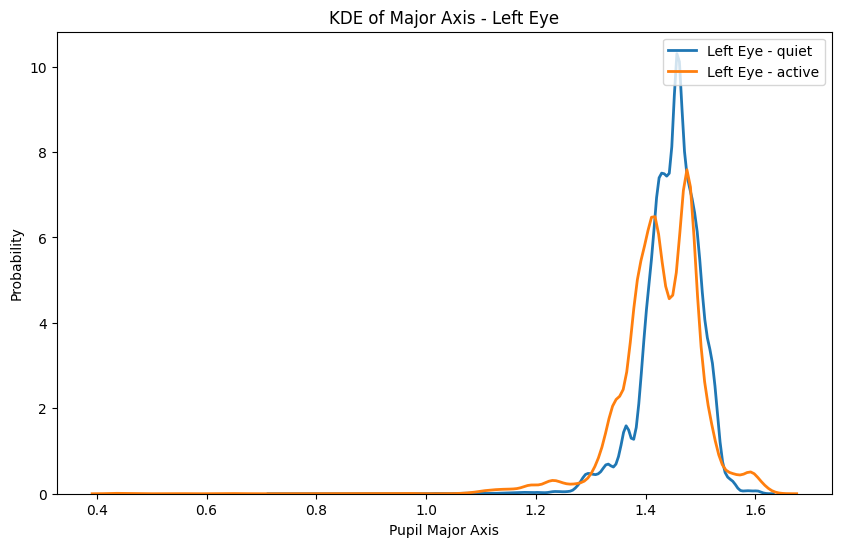

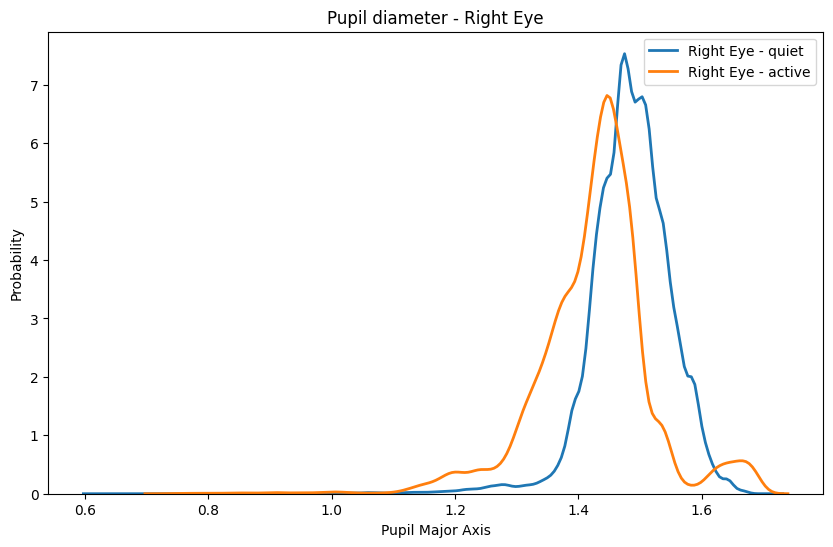

In [29]:
from matplotlib.backends.backend_pdf import PdfPages

def aggregate_and_plot_histograms(behavior_df, left_eye_data, right_eye_data, export_path=None):
    # Convert behavior_df times from seconds to milliseconds
    behavior_df['start_time_ms'] = behavior_df['start_time']
    behavior_df['end_time_ms'] = behavior_df['end_time']

    # Create a dictionary to store major_ax values for each annotation
    left_eye_aggregated = {label: [] for label in behavior_df['annotation'].unique()}
    right_eye_aggregated = {label: [] for label in behavior_df['annotation'].unique()}

    # Loop through each annotation period in behavior_df
    for i, row in behavior_df.iterrows():
        start_time_ms = row['start_time_ms']
        end_time_ms = row['end_time_ms']
        annotation = row['annotation']
        
        # Get left and right eye major_ax values for the corresponding time windows
        left_eye_values = left_eye_data.query('ms_axis > @start_time_ms and ms_axis < @end_time_ms')['pupil_diameter']
        right_eye_values = right_eye_data.query('(ms_axis >= @start_time_ms) and (ms_axis <= @end_time_ms)')['pupil_diameter']
        
        # Append these values to the corresponding annotation label
        left_eye_aggregated[annotation].extend(left_eye_values)
        right_eye_aggregated[annotation].extend(right_eye_values)

    # Prepare to save both figures to the same PDF
    if export_path is not None:
        pdf_pages = PdfPages(export_path)

    # Plot KDE for the left eye with normalization and thicker lines
    plt.figure(figsize=(10, 6))
    for annotation in left_eye_aggregated.keys():
        sns.kdeplot(left_eye_aggregated[annotation], label=f'Left Eye - {annotation}', fill=False, common_norm=False, linewidth=2)
    plt.title('KDE of Major Axis - Left Eye')
    plt.xlabel('Pupil Major Axis')
    plt.ylabel('Probability')
    plt.legend(loc='upper right')
    #plt.ylim(0, 1)
    
    # If export_path is provided, save to PDF
    if export_path is not None:
        pdf_pages.savefig()  # Save the current figure to the PDF
    plt.show()

    # Plot KDE for the right eye with normalization and thicker lines
    plt.figure(figsize=(10, 6))
    for annotation in right_eye_aggregated.keys():
        sns.kdeplot(right_eye_aggregated[annotation], label=f'Right Eye - {annotation}', fill=False, common_norm=False, linewidth=2)
    plt.title('Pupil diameter - Right Eye')
    plt.xlabel('Pupil Major Axis')
    plt.ylabel('Probability')
    #plt.ylim(0, 1)
    plt.legend(loc='upper right')
    plt.grid(False)
    
    # If export_path is provided, save to PDF
    if export_path is not None:
        pdf_pages.savefig()  # Save the current figure to the PDF
        pdf_pages.close()  # Close the PDF after saving both figures

    plt.show()

# Example usage:
export_path = block.analysis_path / 'pupil_behavior_kde_based_on_lizard_movement.pdf'
left_eye_data = block.left_eye_data
right_eye_data = block.right_eye_data
aggregate_and_plot_histograms(block.behavior_state, left_eye_data, right_eye_data, export_path=None)



In [20]:
block.behavior_state['len'] = block.behavior_state['end_time_ms'] - block.behavior_state['start_time_ms']

In [52]:
read_behavior_state(block)

Behavior state successfully loaded from Z:\Nimrod\experiments\PV_126\2024_07_18\block_007\analysis\block_007_behavior_state.csv


start_time   end_time annotation
0       5268.0    19268.0     active
1      19268.0   262268.0      quiet
2     262268.0   264268.0     active
3     264268.0   269268.0      quiet
4     269268.0   280268.0     active
..         ...        ...        ...
75   1698268.0  1708268.0      quiet
76   1708268.0  1726268.0     active
77   1726268.0  1744268.0      quiet
78   1744268.0  1758268.0     active
79   1758268.0  1793268.0      quiet

[80 rows x 3 columns]

In [22]:
block.behavior_state

start_time   end_time annotation  start_time_ms  end_time_ms        len
0      27892.0   250892.0      quiet        27892.0     250892.0   223000.0
1     250892.0   251892.0     active       250892.0     251892.0     1000.0
2     251892.0   398892.0      quiet       251892.0     398892.0   147000.0
3     398892.0   423892.0     active       398892.0     423892.0    25000.0
4     423892.0   671892.0      quiet       423892.0     671892.0   248000.0
5     671892.0   684892.0     active       671892.0     684892.0    13000.0
6     684892.0   731892.0      quiet       684892.0     731892.0    47000.0
7     731892.0   741892.0     active       731892.0     741892.0    10000.0
8     741892.0   762892.0      quiet       741892.0     762892.0    21000.0
9     762892.0   767892.0     active       762892.0     767892.0     5000.0
10    767892.0   864892.0      quiet       767892.0     864892.0    97000.0
11    864892.0   865892.0     active       864892.0     865892.0     1000.0
12    865892.0   878892.0      quiet       865892.0     878892.0    13000.0
13    878892.0   888892.0     active       878892.0     888892.0    10000.0
14    888892.0  1203892.0      quiet       888892.0    1203892.0   315000.0
15   1203892.0  1214892.0     active      1203892.0    1214892.0    11000.0
16   1214892.0  1239892.0      quiet      1214892.0    1239892.0    25000.0
17   1239892.0  1260892.0     active      1239892.0    1260892.0    21000.0
18   1260892.0  1286892.0      quiet      1260892.0    1286892.0    26000.0
19   1286892.0  1301892.0     active      1286892.0    1301892.0    15000.0
20   1301892.0  1350892.0      quiet      1301892.0    1350892.0    49000.0
21   1350892.0  1360892.0     active      1350892.0    1360892.0    10000.0
22   1360892.0  1365892.0      quiet      1360892.0    1365892.0     5000.0
23   1365892.0  1379892.0     active      1365892.0    1379892.0    14000.0
24   1379892.0  3524892.0      quiet      1379892.0    3524892.0  2145000.0
25   3524892.0  3599892.0     active      3524892.0    3599892.0    75000.0
26   3599892.0  3600892.0      quiet      3599892.0    3600892.0     1000.0

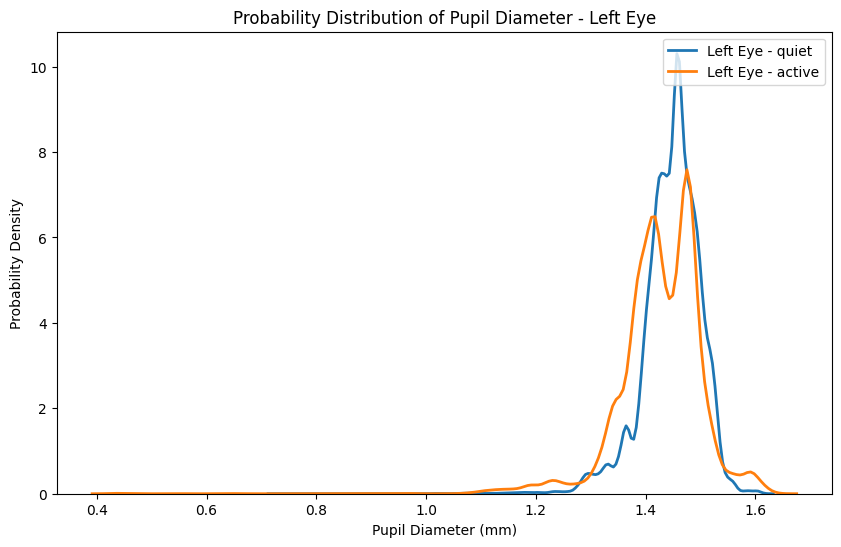

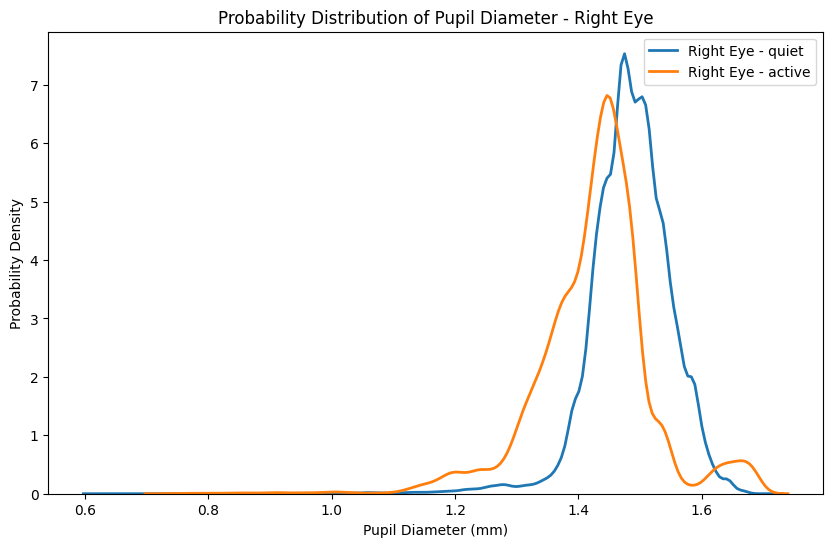

In [30]:
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def aggregate_and_plot_histograms(behavior_df, left_eye_data, right_eye_data, export_path=None):
    """
    Generate and save KDE plots for pupil diameter distributions under different behavioral annotations.

    Args:
        behavior_df (pd.DataFrame): DataFrame with 'start_time', 'end_time', and 'annotation'.
        left_eye_data (pd.DataFrame): DataFrame with 'ms_axis' and 'pupil_diameter' for the left eye.
        right_eye_data (pd.DataFrame): DataFrame with 'ms_axis' and 'pupil_diameter' for the right eye.
        export_path (str): Path to save the PDF containing the plots (optional).
    """
    # Convert behavior_df times from seconds to milliseconds
    behavior_df['start_time_ms'] = behavior_df['start_time']
    behavior_df['end_time_ms'] = behavior_df['end_time']

    # Create dictionaries to store pupil diameters for each annotation
    left_eye_aggregated = {label: [] for label in behavior_df['annotation'].unique()}
    right_eye_aggregated = {label: [] for label in behavior_df['annotation'].unique()}

    # Loop through each annotation period
    for _, row in behavior_df.iterrows():
        start_time_ms = row['start_time_ms']
        end_time_ms = row['end_time_ms']
        annotation = row['annotation']
        
        # Get pupil diameters for the current annotation period
        left_eye_values = left_eye_data.query('ms_axis > @start_time_ms and ms_axis < @end_time_ms')['pupil_diameter']
        right_eye_values = right_eye_data.query('(ms_axis >= @start_time_ms) and (ms_axis <= @end_time_ms)')['pupil_diameter']
        
        left_eye_aggregated[annotation].extend(left_eye_values)
        right_eye_aggregated[annotation].extend(right_eye_values)

    # Prepare to save both figures to the same PDF
    if export_path is not None:
        pdf_pages = PdfPages(export_path)

    # Plot KDE for the left eye with proper normalization
    plt.figure(figsize=(10, 6))
    for annotation, data in left_eye_aggregated.items():
        sns.kdeplot(data, label=f'Left Eye - {annotation}', bw_adjust=1, common_norm=True, fill=False, linewidth=2)
    plt.title('Probability Distribution of Pupil Diameter - Left Eye')
    plt.xlabel('Pupil Diameter (mm)')
    plt.ylabel('Probability Density')
    plt.legend(loc='upper right')
    
    # Save the current plot to the PDF if export_path is provided
    if export_path is not None:
        pdf_pages.savefig()
    plt.show()

    # Plot KDE for the right eye with proper normalization
    plt.figure(figsize=(10, 6))
    for annotation, data in right_eye_aggregated.items():
        sns.kdeplot(data, label=f'Right Eye - {annotation}', bw_adjust=1, common_norm=True, fill=False, linewidth=2)
    plt.title('Probability Distribution of Pupil Diameter - Right Eye')
    plt.xlabel('Pupil Diameter (mm)')
    plt.ylabel('Probability Density')
    plt.legend(loc='upper right')
    
    # Save the current plot to the PDF if export_path is provided
    if export_path is not None:
        pdf_pages.savefig()
        pdf_pages.close()

    plt.show()

# Example usage:
export_path = block.analysis_path / 'pupil_behavior_kde_based_on_lizard_movement.pdf'
left_eye_data = block.left_eye_data
right_eye_data = block.right_eye_data
aggregate_and_plot_histograms(block.behavior_state, left_eye_data, right_eye_data, export_path=None)


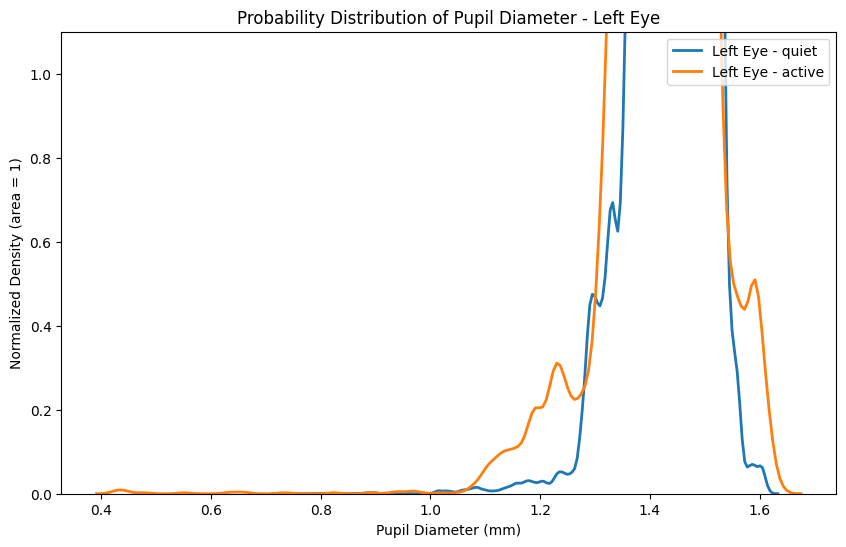

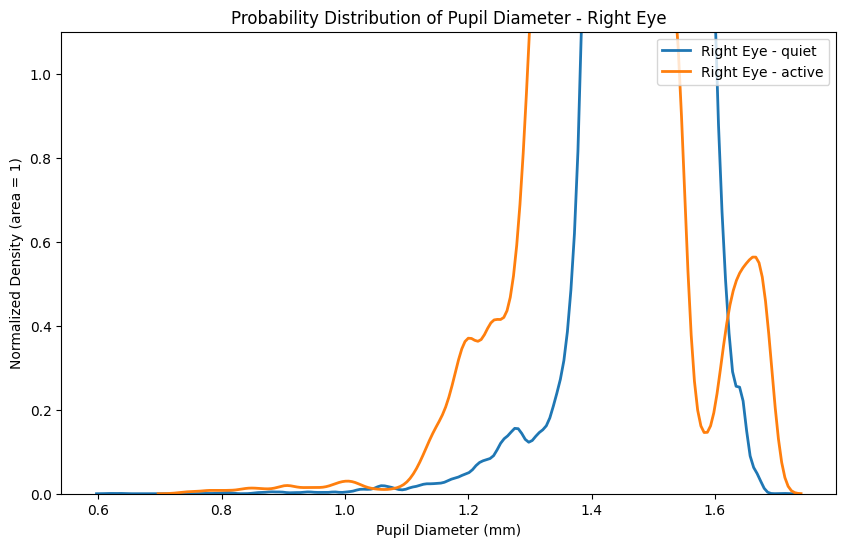

In [32]:
def aggregate_and_plot_histograms(behavior_df, left_eye_data, right_eye_data, export_path=None):
    """
    Generate and save KDE plots for pupil diameter distributions under different behavioral annotations.

    Args:
        behavior_df (pd.DataFrame): DataFrame with 'start_time', 'end_time', and 'annotation'.
        left_eye_data (pd.DataFrame): DataFrame with 'ms_axis' and 'pupil_diameter' for the left eye.
        right_eye_data (pd.DataFrame): DataFrame with 'ms_axis' and 'pupil_diameter' for the right eye.
        export_path (str): Path to save the PDF containing the plots (optional).
    """
    from matplotlib.backends.backend_pdf import PdfPages
    import seaborn as sns
    import matplotlib.pyplot as plt
    import numpy as np

    # Convert behavior_df times from seconds to milliseconds
    behavior_df['start_time_ms'] = behavior_df['start_time']
    behavior_df['end_time_ms'] = behavior_df['end_time']

    # Create dictionaries to store pupil diameters for each annotation
    left_eye_aggregated = {label: [] for label in behavior_df['annotation'].unique()}
    right_eye_aggregated = {label: [] for label in behavior_df['annotation'].unique()}

    # Loop through each annotation period
    for _, row in behavior_df.iterrows():
        start_time_ms = row['start_time_ms']
        end_time_ms = row['end_time_ms']
        annotation = row['annotation']
        
        # Get pupil diameters for the current annotation period
        left_eye_values = left_eye_data.query('ms_axis > @start_time_ms and ms_axis < @end_time_ms')['pupil_diameter']
        right_eye_values = right_eye_data.query('(ms_axis >= @start_time_ms) and (ms_axis <= @end_time_ms)')['pupil_diameter']
        
        left_eye_aggregated[annotation].extend(left_eye_values)
        right_eye_aggregated[annotation].extend(right_eye_values)

    # Prepare to save both figures to the same PDF
    if export_path is not None:
        pdf_pages = PdfPages(export_path)

    # Plot KDE for the left eye
    plt.figure(figsize=(10, 6))
    for annotation, data in left_eye_aggregated.items():
        sns.kdeplot(data, label=f'Left Eye - {annotation}', fill=False, linewidth=2, bw_adjust=1)
    plt.title('Probability Distribution of Pupil Diameter - Left Eye')
    plt.xlabel('Pupil Diameter (mm)')
    plt.ylabel('Normalized Density (area = 1)')
    plt.legend(loc='upper right')
    plt.ylim(0, 1.1)  # Normalize the y-axis if desired

    # Save the current plot to the PDF if export_path is provided
    if export_path is not None:
        pdf_pages.savefig()
    plt.show()

    # Plot KDE for the right eye
    plt.figure(figsize=(10, 6))
    for annotation, data in right_eye_aggregated.items():
        sns.kdeplot(data, label=f'Right Eye - {annotation}', fill=False, linewidth=2, bw_adjust=1)
    plt.title('Probability Distribution of Pupil Diameter - Right Eye')
    plt.xlabel('Pupil Diameter (mm)')
    plt.ylabel('Normalized Density (area = 1)')
    plt.legend(loc='upper right')
    plt.ylim(0, 1.1)  # Normalize the y-axis if desired

    # Save the current plot to the PDF if export_path is provided
    if export_path is not None:
        pdf_pages.savefig()
        pdf_pages.close()

    plt.show()

aggregate_and_plot_histograms(block.behavior_state, left_eye_data, right_eye_data, export_path=None)

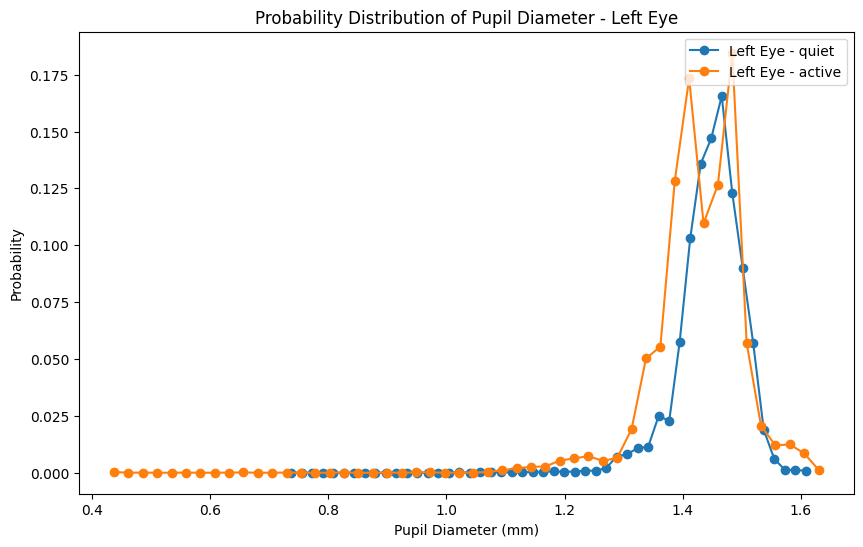

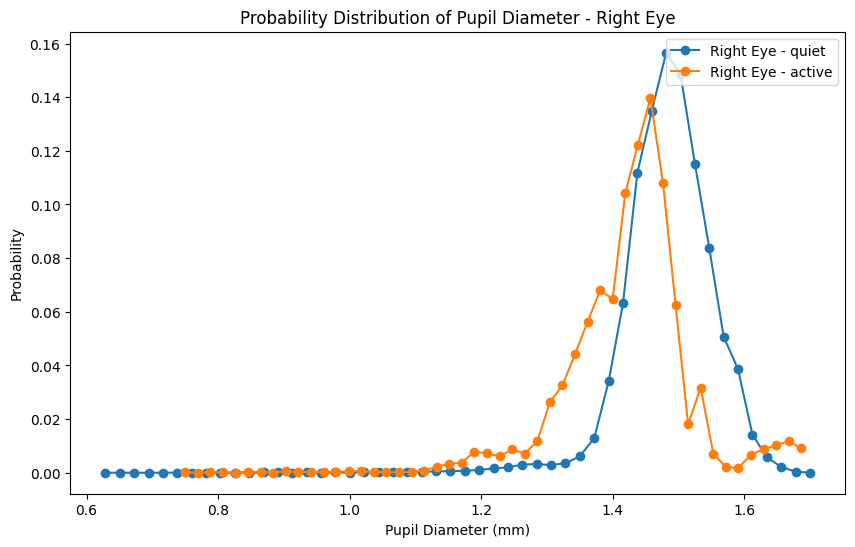

In [34]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages

def aggregate_and_plot_probabilities(behavior_df, left_eye_data, right_eye_data, export_path=None, num_bins=50):
    """
    Generate and save probability plots for pupil diameter distributions under different behavioral annotations.

    Args:
        behavior_df (pd.DataFrame): DataFrame with 'start_time', 'end_time', and 'annotation'.
        left_eye_data (pd.DataFrame): DataFrame with 'ms_axis' and 'pupil_diameter' for the left eye.
        right_eye_data (pd.DataFrame): DataFrame with 'ms_axis' and 'pupil_diameter' for the right eye.
        export_path (str): Path to save the PDF containing the plots (optional).
        num_bins (int): Number of bins to divide the pupil diameter values.
    """
    # Convert behavior_df times from seconds to milliseconds
    behavior_df['start_time_ms'] = behavior_df['start_time']
    behavior_df['end_time_ms'] = behavior_df['end_time']

    # Create dictionaries to store pupil diameters for each annotation
    left_eye_aggregated = {label: [] for label in behavior_df['annotation'].unique()}
    right_eye_aggregated = {label: [] for label in behavior_df['annotation'].unique()}

    # Loop through each annotation period
    for _, row in behavior_df.iterrows():
        start_time_ms = row['start_time_ms']
        end_time_ms = row['end_time_ms']
        annotation = row['annotation']
        
        # Get pupil diameters for the current annotation period
        left_eye_values = left_eye_data.query('ms_axis > @start_time_ms and ms_axis < @end_time_ms')['pupil_diameter']
        right_eye_values = right_eye_data.query('(ms_axis >= @start_time_ms) and (ms_axis <= @end_time_ms)')['pupil_diameter']
        
        # Remove NaN values
        left_eye_values = left_eye_values.dropna()
        right_eye_values = right_eye_values.dropna()
        
        left_eye_aggregated[annotation].extend(left_eye_values)
        right_eye_aggregated[annotation].extend(right_eye_values)

    # Prepare to save both figures to the same PDF
    if export_path is not None:
        pdf_pages = PdfPages(export_path)

    # Plot probabilities for the left eye
    plt.figure(figsize=(10, 6))
    for annotation, data in left_eye_aggregated.items():
        data = np.array(data)
        data = data[~np.isnan(data)]  # Ensure no NaN values
        counts, bin_edges = np.histogram(data, bins=num_bins, density=True)
        probabilities = counts / np.sum(counts)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        plt.plot(bin_centers, probabilities, label=f'Left Eye - {annotation}', marker='o')
    plt.title('Probability Distribution of Pupil Diameter - Left Eye')
    plt.xlabel('Pupil Diameter (mm)')
    plt.ylabel('Probability')
    plt.legend(loc='upper right')

    # Save the current plot to the PDF if export_path is provided
    if export_path is not None:
        pdf_pages.savefig()
    plt.show()

    # Plot probabilities for the right eye
    plt.figure(figsize=(10, 6))
    for annotation, data in right_eye_aggregated.items():
        data = np.array(data)
        data = data[~np.isnan(data)]  # Ensure no NaN values
        counts, bin_edges = np.histogram(data, bins=num_bins, density=True)
        probabilities = counts / np.sum(counts)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        plt.plot(bin_centers, probabilities, label=f'Right Eye - {annotation}', marker='o')
    plt.title('Probability Distribution of Pupil Diameter - Right Eye')
    plt.xlabel('Pupil Diameter (mm)')
    plt.ylabel('Probability')
    plt.legend(loc='upper right')

    # Save the current plot to the PDF if export_path is provided
    if export_path is not None:
        pdf_pages.savefig()
        pdf_pages.close()

    plt.show()

# Example usage:
export_path = block.analysis_path / 'pupil_behavior_probabilities_based_on_lizard_movement.pdf'
left_eye_data = block.left_eye_data
right_eye_data = block.right_eye_data
aggregate_and_plot_probabilities(block.behavior_state, left_eye_data, right_eye_data, export_path=None)


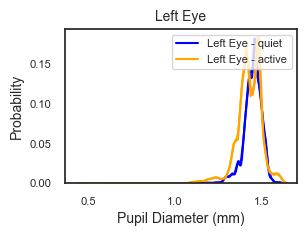

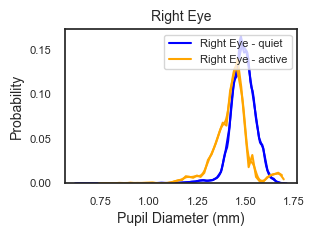

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages

def aggregate_and_plot_probabilities_seaborn(block, export_path=None, num_bins=50):
    """
    Generate and save elegant Seaborn-based probability plots for pupil diameter distributions.

    Args:
        block: BlockSync object with the following internal attributes:
            behavior_df (pd.DataFrame): DataFrame with 'start_time', 'end_time', and 'annotation'.
            left_eye_data (pd.DataFrame): DataFrame with 'ms_axis' and 'pupil_diameter' for the left eye.
            right_eye_data (pd.DataFrame): DataFrame with 'ms_axis' and 'pupil_diameter' for the right eye.
        export_path (str): Path to save the PDF containing the plots (optional).
        num_bins (int): Number of bins to divide the pupil diameter values.
    """
    behavior_df = block.behavior_state
    left_eye_data = block.left_eye_data
    right_eye_data = block.right_eye_data
    # Convert behavior_df times from seconds to milliseconds
    behavior_df['start_time_ms'] = behavior_df['start_time']
    behavior_df['end_time_ms'] = behavior_df['end_time']

    # Create dictionaries to store pupil diameters for each annotation
    left_eye_aggregated = {label: [] for label in behavior_df['annotation'].unique()}
    right_eye_aggregated = {label: [] for label in behavior_df['annotation'].unique()}

    # Loop through each annotation period
    for _, row in behavior_df.iterrows():
        start_time_ms = row['start_time_ms']
        end_time_ms = row['end_time_ms']
        annotation = row['annotation']
        
        # Get pupil diameters for the current annotation period
        left_eye_values = left_eye_data.query('ms_axis > @start_time_ms and ms_axis < @end_time_ms')['pupil_diameter'].dropna()
        right_eye_values = right_eye_data.query('(ms_axis >= @start_time_ms) and (ms_axis <= @end_time_ms)')['pupil_diameter'].dropna()
        
        left_eye_aggregated[annotation].extend(left_eye_values)
        right_eye_aggregated[annotation].extend(right_eye_values)

    # Prepare to save both figures to the same PDF
    if export_path is not None:
        pdf_pages = PdfPages(export_path)

    # Seaborn styling
    sns.set(style="white")
     # Custom color mapping
    color_map = {'quiet': 'blue', 'active': 'orange'}
    # Plot probabilities for the left eye
    plt.figure(figsize=(3, 2), dpi=100)
    for annotation, data in left_eye_aggregated.items():
        sns.histplot(data, bins=num_bins, stat='probability', element='poly', kde=True, label=f'Left Eye - {annotation}', alpha=0.7,
                     color=color_map.get(annotation, 'gray'), fill=False)
    plt.title('Left Eye', fontsize=10)
    plt.xlabel('Pupil Diameter (mm)', fontsize=10)
    plt.ylabel('Probability', fontsize=10)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.legend(loc='upper right', fontsize=8)
    
    # Save the current plot to the PDF if export_path is provided
    if export_path is not None:
        pdf_pages.savefig()
    plt.show()

    # Plot probabilities for the right eye
    plt.figure(figsize=(3, 2), dpi=100)
    for annotation, data in right_eye_aggregated.items():
        sns.histplot(data, bins=num_bins, stat='probability', element='poly', kde=True, label=f'Right Eye - {annotation}', alpha=0.7,
                    color=color_map.get(annotation, 'gray'), fill=False)
        
    plt.title('Right Eye', fontsize=10)
    plt.xlabel('Pupil Diameter (mm)', fontsize=10)
    plt.ylabel('Probability', fontsize=10)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.legend(loc='upper right', fontsize=8)

    # Save the current plot to the PDF if export_path is provided
    if export_path is not None:
        pdf_pages.savefig()
        pdf_pages.close()

    plt.show()

# Example usage:
export_path = block.analysis_path / 'pupil_behavior_probabilities_based_on_lizard_movement_seaborn.pdf'
left_eye_data = block.left_eye_data
right_eye_data = block.right_eye_data
aggregate_and_plot_probabilities_seaborn(block, export_path=None)


In [ ]:
#TODO:
# 1. get a probability graph with 0-1 value range (prob.) for each condition
# 2. as a control, check correlation between pupil diameter and location in frame
# 3. 

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np

def aggregate_and_plot_probabilities_multi_blocks(block_list, export_path=None, num_bins=50):
    """
    Generate and save elegant Seaborn-based probability plots for pupil diameter distributions
    across multiple blocks.

    Args:
        block_list: List of BlockSync objects with the following internal attributes:
            - behavior_df (pd.DataFrame): DataFrame with 'start_time', 'end_time', and 'annotation'.
            - left_eye_data (pd.DataFrame): DataFrame with 'ms_axis' and 'pupil_diameter' for the left eye.
            - right_eye_data (pd.DataFrame): DataFrame with 'ms_axis' and 'pupil_diameter' for the right eye.
        export_path (str): Path to save the PDF containing the plots (optional).
        num_bins (int): Number of bins to divide the pupil diameter values.
    """
    # Initialize combined dictionaries for all blocks
    left_eye_aggregated = {}
    right_eye_aggregated = {}
    
    # Loop through each block to aggregate data
    for block in block_list:
        behavior_df = block.behavior_state
        left_eye_data = block.left_eye_data
        right_eye_data = block.right_eye_data

        # Convert behavior_df times from seconds to milliseconds
        behavior_df['start_time_ms'] = behavior_df['start_time']
        behavior_df['end_time_ms'] = behavior_df['end_time']

        # Initialize aggregation for new annotations
        for label in behavior_df['annotation'].unique():
            if label not in left_eye_aggregated:
                left_eye_aggregated[label] = []
            if label not in right_eye_aggregated:
                right_eye_aggregated[label] = []

        # Aggregate data per annotation period
        for _, row in behavior_df.iterrows():
            start_time_ms = row['start_time_ms']
            end_time_ms = row['end_time_ms']
            annotation = row['annotation']
            
            # Get pupil diameters for the current annotation period
            left_eye_values = left_eye_data.query('ms_axis > @start_time_ms and ms_axis < @end_time_ms')['pupil_diameter'].dropna()
            right_eye_values = right_eye_data.query('(ms_axis >= @start_time_ms) and (ms_axis <= @end_time_ms)')['pupil_diameter'].dropna()
            
            left_eye_aggregated[annotation].extend(left_eye_values)
            right_eye_aggregated[annotation].extend(right_eye_values)

    # Prepare to save both figures to the same PDF
    if export_path is not None:
        pdf_pages = PdfPages(export_path)

    # Seaborn styling
    sns.set(style="white")
    color_map = {'quiet': 'blue', 'active': 'orange'}

    # Plot probabilities for the left eye
    plt.figure(figsize=(3, 2), dpi=100)
    for annotation, data in left_eye_aggregated.items():
        sns.histplot(data, bins=num_bins, stat='probability', element='poly', kde=True,
                     label=f'Left Eye - {annotation}', alpha=0.7,
                     color=color_map.get(annotation, 'gray'), fill=False)
    plt.title('Left Eye', fontsize=10)
    plt.xlabel('Pupil Diameter (mm)', fontsize=10)
    plt.ylabel('Probability', fontsize=10)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.legend(loc='upper right', fontsize=8)
    if export_path is not None:
        pdf_pages.savefig()
    plt.show()

    # Plot probabilities for the right eye
    plt.figure(figsize=(3, 2), dpi=100)
    for annotation, data in right_eye_aggregated.items():
        sns.histplot(data, bins=num_bins, stat='probability', element='poly', kde=True,
                     label=f'Right Eye - {annotation}', alpha=0.7,
                     color=color_map.get(annotation, 'gray'), fill=False)
    plt.title('Right Eye', fontsize=10)
    plt.xlabel('Pupil Diameter (mm)', fontsize=10)
    plt.ylabel('Probability', fontsize=10)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.legend(loc='upper right', fontsize=8)
    if export_path is not None:
        pdf_pages.savefig()

    if export_path is not None:
        pdf_pages.close()

    plt.show()


In [12]:
import pandas as pd

def read_behavior_state(block):
    """
    Reads the behavior_state CSV file from the block's analysis folder and assigns it to the block object.

    Args:
        block (BlockSync): The block object containing metadata about the analysis folder.

    Returns:
        pd.DataFrame: The loaded behavior state dataframe.
    """
    try:
        # Construct the path to the CSV file
        csv_path = block.analysis_path / f"block_{block.block_num}_behavior_state.csv"
        
        if not csv_path.exists():
            raise FileNotFoundError(f"No behavior_state file found at {csv_path}")
        
        # Read the CSV into a DataFrame
        behavior_state_df = pd.read_csv(csv_path)
        
        # Assign it to the block object for easy access
        block.behavior_state = behavior_state_df
        print(f"Behavior state successfully loaded from {csv_path}")
        
        return behavior_state_df
    
    except Exception as e:
        print(f"Error reading behavior state: {e}")
        return None

def create_distance_plot(distances, top_dist_to_show=500):
    # Create cumulative distribution plot
    sns.set(style="whitegrid")
    fig, axs = plt.subplots(2, figsize=(6, 6), dpi=150)
    
    axs[0].set_title('Cumulative Euclidean Distances for Camera Jitter', fontsize=15)
    axs[0].set_ylabel('Cumulative \n % of Frames')
    axs[0].set_xlim(0, top_dist_to_show)
    axs[0].grid(False)
    
    # Create histogram and cumulative distribution
    sns.kdeplot(distances, cumulative=True, label='Left Eye', ax=axs[0], linewidth=4, c='black')
    
    axs[1].hist(distances, bins=np.linspace(0, top_dist_to_show, 20), log=False, color='black')

    # Set title and labels
    title = 'Image displacement histogram'
    axs[1].set_title(title, fontsize=15)
    axs[1].set_xlabel('Euclidean Displacement [$\mu$m]', fontsize=15)
    axs[1].set_xscale('linear')
    axs[1].set_yscale('linear')
    axs[1].set_ylabel('Frame count', fontsize=15)

    # Adjust tick label sizes
    axs[1].tick_params(axis='x', which='major', labelsize=15)

    # Set white background and black text
    axs[1].set_facecolor('white')
    axs[1].title.set_color('black')
    axs[1].xaxis.label.set_color('black')
    axs[1].yaxis.label.set_color('black')
    axs[1].tick_params(colors='black')
    axs[1].grid(False)

    plt.tight_layout()

    return fig, axs
def add_intermediate_elements(input_vector, gap_to_bridge):
    # Step 1: Calculate differences between each element
    differences = np.diff(input_vector)

    # Step 2: Add intervening elements based on the diff_threshold
    output_vector = [input_vector[0]]
    for i, diff in enumerate(differences):
        if diff < gap_to_bridge:
            # Add intervening elements
            output_vector.extend(range(input_vector[i] + 1, input_vector[i + 1]))

        # Add the next element from the original vector
        output_vector.append(input_vector[i + 1])

    return np.sort(np.unique(output_vector))

def find_jittery_frames(block, eye, max_distance, diff_threshold, gap_to_bridge=6):
    
    #input checks
    if eye not in ['left', 'right']:
        print(f'eye can only be left/right, your input: {eye}')
        return None
    # eye setup
    if eye == 'left':
        jitter_dict = block.le_jitter_dict
        eye_frame_col = 'L_eye_frame'
    elif eye == 'right':
        jitter_dict = block.re_jitter_dict
        eye_frame_col = 'R_eye_frame'
    
    df_dict = {'left':block.le_df,
               'right':block.re_df}
    
    df = pd.DataFrame.from_dict(jitter_dict)
    indices_of_highest_drift = df.query("top_correlation_dist > @max_distance").index.values
    diff_vec = np.diff(df['top_correlation_dist'].values)
    diff_peaks_indices = np.where(diff_vec > diff_threshold)[0]
    video_indices = np.concatenate((diff_peaks_indices, indices_of_highest_drift))
    print(f'the diff based jitter frame exclusion gives: {np.shape(diff_peaks_indices)}')
    print(f'the threshold based jitter frame exclusion gives: {np.shape(indices_of_highest_drift)}')
    
    # creates a bridged version of the overly jittery frames (to contend with single frame outliers)
    video_indices = add_intermediate_elements(video_indices, gap_to_bridge=gap_to_bridge)
    # This is the input you should give to the BlockSync.remove_eye_datapoints function (which already maps it to the df) 
    
    
    # translates the video indices to le/re dataframe rows
    df_indices_to_remove = df_dict[eye].loc[df_dict[eye][eye_frame_col].isin(video_indices)].index.values
    
    return df_indices_to_remove, video_indices

def bokeh_plotter(data_list, label_list,
                  plot_name='default',
                  x_axis='X', y_axis='Y',
                  peaks=None, peaks_list=False, export_path=False):
    """Generates an interactive Bokeh plot for the given data vector.
    Args:
        data_list (list or array): The data to be plotted.
        label_list (list of str): The labels of the data vectors
        plot_name (str, optional): The title of the plot. Defaults to 'default'.
        x_axis (str, optional): The label for the x-axis. Defaults to 'X'.
        y_axis (str, optional): The label for the y-axis. Defaults to 'Y'.
        peaks (list or array, optional): Indices of peaks to highlight on the plot. Defaults to None.
        export_path (False or str): when set to str, will output the resulting html fig
    """
    color_cycle = cycle(bokeh.palettes.Category10_10)
    fig = bokeh.plotting.figure(title=f'bokeh explorer: {plot_name}',
                                x_axis_label=x_axis,
                                y_axis_label=y_axis,
                                plot_width=1500,
                                plot_height=700)

    for i, vec in enumerate(range(len(data_list))):
        color = next(color_cycle)
        data_vector = data_list[vec]
        if label_list is None:
            fig.line(range(len(data_vector)), data_vector, line_color=color, legend_label=f"Line {len(fig.renderers)}")
        elif len(label_list) == len(data_list):
            fig.line(range(len(data_vector)), data_vector, line_color=color, legend_label=f"{label_list[i]}")
        if peaks is not None and peaks_list is True:
            fig.circle(peaks[i], data_vector[peaks[i]], size=10, color=color)

    if peaks is not None and peaks_list is False:
        fig.circle(peaks, data_vector[peaks], size=10, color='red')

    if export_path is not False:
        print(f'exporting to {export_path}')
        bokeh.io.output.output_file(filename=str(export_path / f'{plot_name}.html'), title=f'{plot_name}')
    bokeh.plotting.show(fig)
    



# Block Instantiation

In [13]:

# define a single block to synchronize and finally export l/r_eye_data csv files:
# this step creates block_collection - a list of BlockSync objects of interest
#animal = 'PV_126'||block_numbers = [7,8,9,10,11,12,13,14]
bad_blocks = [6] # 
experiment_path = pathlib.Path(r"Z:\Nimrod\experiments")
animal = 'PV_62'
block_numbers = [23,24,25,26,27]

block_collection = uf.block_generator(block_numbers=block_numbers,
                                      experiment_path=experiment_path,
                                      animal=animal,
                                      bad_blocks=bad_blocks,regev=True)
# create a block_dict object for ease of access:
block_dict = {}
for b in block_collection:
    block_dict[str(b.block_num)] = b
block = block_collection[0]

instantiated block number 023 at Path: Z:\Nimrod\experiments\PV_62\2023_04_27\block_023, new OE version
Found the sample rate for block 023 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 023
got it!
instantiated block number 024 at Path: Z:\Nimrod\experiments\PV_62\2023_04_27\block_024, new OE version
Found the sample rate for block 024 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 024
got it!
instantiated block number 025 at Path: Z:\Nimrod\experiments\PV_62\2023_04_27\block_025, new OE version
Found the sample rate for block 025 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 025
got it!
instantiated block number 026 at Path: Z:\Nimrod\experi

In [14]:
for block in block_collection:
    block.parse_open_ephys_events()
    block.get_eye_brightness_vectors()
    block.synchronize_block()
    block.create_eye_brightness_df(threshold_value=20)

    # if the code fails here, go to manual synchronization
    block.import_manual_sync_df()
    block.read_dlc_data()
    block.calibrate_pixel_size(10)
    load_eye_data_2d_w_rotation_matrix(block) #should be integrated again... later
    
    # calibrate pupil diameter:

    block.left_eye_data['pupil_diameter_pixels'] = block.left_eye_data.major_ax * 2 * np.pi
    block.right_eye_data['pupil_diameter_pixels'] = block.right_eye_data.major_ax * 2 * np.pi
    block.left_eye_data['pupil_diameter'] = block.left_eye_data['pupil_diameter_pixels'] * block.L_pix_size
    block.right_eye_data['pupil_diameter'] = block.right_eye_data['pupil_diameter_pixels'] * block.R_pix_size

running parse_open_ephys_events...
block 023 has a parsed events file, reading...
Getting eye brightness values for block 023...
Found an existing file!
Eye brightness vectors generation complete.
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
eye dataframes loaded from analysis folder
got the calibration values from the analysis folder
running parse_open_ephys_events...
block 024 has a parsed events file, reading...
Getting eye brightness values for block 024...
Found an existing file!
Eye brightness vectors generation complete.
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
eye dataframes loaded from analysis folder
got the calibration values from the analysis folder
running parse_open_ephys_events...
block 025 has a parsed events file, reading...
Getting eye brightness values for block 025...
Found an existing file!
Eye brightness vectors generation complete.
blocksync_df loaded from analysis folder
eye_

In [15]:
for block in block_collection:
    block.block_get_lizard_movement()
    read_behavior_state(block)

path to mat file is Z:\Nimrod\experiments\PV_62\2023_04_27\block_023\oe_files\2023-04-27_10-52-42\Record Node 108\analysis\recNames=Block0023,Animal=PV_62\lizMov.mat
liz_mov_df created for PV_62, block 023, on 2023-04-27_10-52-42
Behavior state successfully loaded from Z:\Nimrod\experiments\PV_62\2023_04_27\block_023\analysis\block_023_behavior_state.csv
path to mat file is Z:\Nimrod\experiments\PV_62\2023_04_27\block_024\oe_files\2023-04-27_11-22-56\Record Node 108\analysis\recNames=Block0024,Animal=PV_62\lizMov.mat
liz_mov_df created for PV_62, block 024, on 2023-04-27_11-22-56
Behavior state successfully loaded from Z:\Nimrod\experiments\PV_62\2023_04_27\block_024\analysis\block_024_behavior_state.csv
path to mat file is Z:\Nimrod\experiments\PV_62\2023_04_27\block_025\oe_files\2023-04-27_11-52-05\Record Node 108\analysis\recNames=Block0025,Animal=PV_62\lizMov.mat
liz_mov_df created for PV_62, block 025, on 2023-04-27_11-52-05
Behavior state successfully loaded from Z:\Nimrod\experi

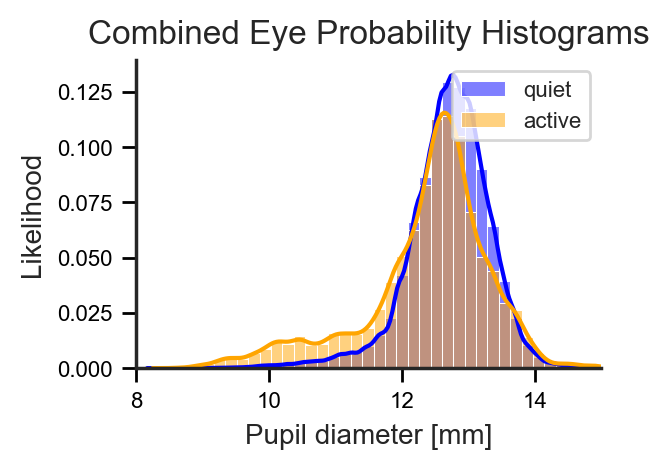

In [16]:
import os
%matplotlib inline
plt.style.use('default')
rcParams['pdf.fonttype'] = 42  # Ensure fonts are embedded and editable
rcParams['ps.fonttype'] = 42  # Ensure compatibility with vector outputs
def plot_combined_eye_probability_histograms(block_list, export_path=None, num_bins=50, x_range=(8, 15), outlier_percentiles=(0.001, 99.999)):
    """
    Generate and save Seaborn-based probability histograms for pupil diameter distributions
    across multiple blocks, with outlier removal and consistent bin widths. Combines left and right eye
    data for each annotation into a single curve. Outputs results into a timestamped folder.

    Args:
        block_list: List of BlockSync objects with the following internal attributes:
            - behavior_df (pd.DataFrame): DataFrame with 'start_time', 'end_time', and 'annotation'.
            - left_eye_data (pd.DataFrame): DataFrame with 'ms_axis' and 'pupil_diameter' for the left eye.
            - right_eye_data (pd.DataFrame): DataFrame with 'ms_axis' and 'pupil_diameter' for the right eye.
        export_path (str): Path to save the output (folder created automatically if None is provided).
        num_bins (int): Number of bins to divide the pupil diameter values.
        x_range (tuple): Tuple specifying the x-axis range (min, max).
        outlier_percentiles (tuple): Percentile range to retain (e.g., (1, 99) keeps the central 98%).
    """
    # Initialize combined dictionaries for all blocks
    combined_aggregated = {}

    # Aggregate data and remove outliers
    all_data = []  # To calculate shared bin edges
    for block in block_list:
        behavior_df = block.behavior_state
        left_eye_data = block.left_eye_data
        right_eye_data = block.right_eye_data

        # Convert behavior_df times from seconds to milliseconds
        behavior_df['start_time_ms'] = behavior_df['start_time']
        behavior_df['end_time_ms'] = behavior_df['end_time']

        # Initialize aggregation for new annotations
        for label in behavior_df['annotation'].unique():
            if label not in combined_aggregated:
                combined_aggregated[label] = []

        # Aggregate data per annotation period
        for _, row in behavior_df.iterrows():
            start_time_ms = row['start_time_ms']
            end_time_ms = row['end_time_ms']
            annotation = row['annotation']

            # Get pupil diameters for the current annotation period
            left_eye_values = left_eye_data.query('ms_axis > @start_time_ms and ms_axis < @end_time_ms')['pupil_diameter'].dropna()
            right_eye_values = right_eye_data.query('ms_axis >= @start_time_ms and ms_axis <= @end_time_ms')['pupil_diameter'].dropna()

            # Combine data from both eyes
            combined_aggregated[annotation].extend(left_eye_values)
            combined_aggregated[annotation].extend(right_eye_values)

            # Collect all data for bin edge calculation
            all_data.extend(left_eye_values)
            all_data.extend(right_eye_values)

    # Determine shared bin edges
    outlier_min, outlier_max = np.percentile(all_data, outlier_percentiles)
    bin_edges = np.linspace(max(outlier_min, x_range[0]), min(outlier_max, x_range[1]), num_bins + 1)

    # Seaborn styling
    sns.set(style="white")
    color_map = {'quiet': 'blue', 'active': 'orange'}

    # Plot combined data for all annotations
    fig, ax = plt.subplots(figsize=(3, 2), dpi=200)
    for annotation, data in combined_aggregated.items():
        # Remove outliers
        filtered_data = [val for val in data if outlier_min <= val <= outlier_max]
        sns.histplot(
            filtered_data,
            bins=bin_edges,
            stat='probability',
            element='bars',
            label=f'{annotation}',
            alpha=0.5,
            color=color_map.get(annotation, 'gray'),kde=True,
            ax=ax,
        )
    ax.set_title('Combined Eye Probability Histograms', fontsize=12)
    ax.set_xlabel('Pupil diameter [mm]', fontsize=10)
    ax.set_ylabel('Likelihood', fontsize=10)
    ax.tick_params(axis='both', labelsize=8)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis='both', direction='out', which='major',length=5, width=1, colors='black', bottom=True, left=True)
    ax.tick_params(axis='both', direction='out', which='minor', length=5, width=1,colors='black', bottom=True, left=True)
    ax.set_xlim(x_range)
    ax.legend(loc='upper right', fontsize=8)

    # Export section
    if export_path is not None:
        # Create timestamped folder
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"pupil_diameter_by_behavior_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)

        # Save plot
        pdf_file = os.path.join(full_export_path, "pupil_diameter_by_behavior.pdf")
        fig.savefig(pdf_file, format='pdf', bbox_inches='tight', dpi=300)

        # Save raw data
        data_file = os.path.join(full_export_path, "combined_aggregated_data.pkl")
        with open(data_file, 'wb') as f:
            pickle.dump(combined_aggregated, f)

        print(f"Exported plot and data to: {full_export_path}")

    plt.show()
export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_4\material\pupil_diameter_behavior_pv62'
plot_combined_eye_probability_histograms(block_collection, export_path=None, num_bins=40, x_range=(8, 15))

In [22]:
import numpy as np
import pickle
from tqdm import tqdm

def monte_carlo_randomization_combined(data_file, condition1, condition2, n_permutations=10000):
    """
    Monte Carlo randomization test for combined eye data.

    Args:
        data_file (str): Path to the exported aggregated data pickle file.
        condition1 (str): First condition (e.g., 'quiet').
        condition2 (str): Second condition (e.g., 'active').
        n_permutations (int): Number of random shuffles for the test.

    Returns:
        dict: Contains observed statistic, p-value, and null distribution.
    """
    # Load combined data
    with open(data_file, 'rb') as f:
        data = pickle.load(f)

    # Extract data for the two conditions
    data1 = np.array(data[condition1])
    data2 = np.array(data[condition2])

    # Calculate observed difference in means
    observed_stat = np.mean(data1) - np.mean(data2)

    # Combine all data and labels
    combined_data = np.concatenate((data1, data2))
    labels = np.array([1] * len(data1) + [0] * len(data2))

    # Null distribution from shuffled labels
    null_dist = []
    for _ in tqdm(range(n_permutations), desc="Shuffling iterations"):
        np.random.shuffle(labels)
        shuffled_data1 = combined_data[labels == 1]
        shuffled_data2 = combined_data[labels == 0]
        null_dist.append(np.mean(shuffled_data1) - np.mean(shuffled_data2))

    # Calculate p-value
    p_value = (np.sum(np.abs(null_dist) >= np.abs(observed_stat)) + 1) / (n_permutations + 1)

    # Return results
    return {
        "observed_stat": observed_stat,
        "p_value": p_value,
        "null_distribution": null_dist
    }


In [23]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def plot_null_distribution(result_dict):
    """
    Visualize the null distribution and observed statistic.

    Args:
        result_dict (dict): Output from the Monte Carlo calculation function.
                            Must contain "observed_stat" and "null_distribution".
    """
    observed_stat = result_dict["observed_stat"]
    null_dist = result_dict["null_distribution"]

    # Create the figure
    fig, ax = plt.subplots(figsize=(3, 2), dpi=150)

    # Density estimation for the null distribution
    kde = gaussian_kde(null_dist)
    x_vals = np.linspace(min(null_dist), max(null_dist), 500)
    y_vals = kde(x_vals)

    # Plot shaded null distribution
    ax.fill_between(x_vals, y_vals, color='blue', alpha=0.5, label='Shuffled Distribution')

    # Mark the observed statistic
    ax.axvline(observed_stat, color='red', linestyle='--', label=f'Observed Value: {observed_stat:.3f}')

    # Customize plot aesthetics
    ax.set_title("Null Distribution vs Observed Statistic", fontsize=10)
    ax.set_xlabel("Difference in Means", fontsize=10)
    ax.set_ylabel("Density", fontsize=10)
    ax.tick_params(axis='both', labelsize=8)
    ax.legend(fontsize=8)

    # Display plot
    plt.tight_layout()
    plt.show()


In [24]:
data_file = r"Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_4\material\pupil_diameter_behavior_pv62\pupil_diameter_by_behavior_2024_12_25_00_47_11\combined_aggregated_data.pkl"
result = monte_carlo_randomization_combined(data_file, 'quiet', 'active', n_permutations=10000)
print(f"Observed Stat: {result['observed_stat']}")
print(f"P-Value: {result['p_value']}")


Shuffling iterations: 100%|██████████| 10000/10000 [03:36<00:00, 46.27it/s]

Observed Stat: 0.3252451077572438
P-Value: 9.999000099990002e-05


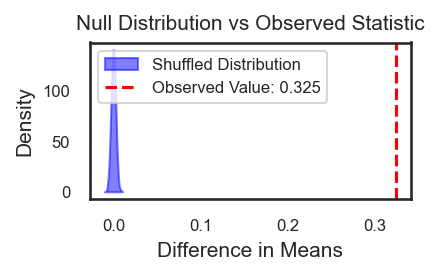

In [25]:
plot_null_distribution(result)

In [18]:
# perform a monte-carlo shuffle statistical analysis:
import numpy as np
import pickle
from scipy.stats import percentileofscore

def monte_carlo_randomization_test_pupil_separate_eyes(data_file, condition1, condition2, n_permutations=10000):
    """
    Monte Carlo randomization test for pupil diameter differences between two conditions.
    
    Args:
        data_file (str): Path to the exported aggregated data pickle file.
        condition1 (str): First condition (e.g., 'quiet').
        condition2 (str): Second condition (e.g., 'active').
        n_permutations (int): Number of random shuffles for the test.
        
    Returns:
        dict: Contains observed statistic, p-value, and null distribution.
    """
    # Load aggregated data
    with open(data_file, 'rb') as f:
        data = pickle.load(f)

    # Extract data for left and right eyes
    left_eye = data['left_eye']
    right_eye = data['right_eye']

    # Combine data for both conditions
    data1 = np.array(left_eye[condition1] + right_eye[condition1])
    data2 = np.array(left_eye[condition2] + right_eye[condition2])

    # Calculate observed difference in means
    observed_stat = np.mean(data1) - np.mean(data2)

    # Combine all data and labels
    combined_data = np.concatenate((data1, data2))
    labels = np.array([1] * len(data1) + [0] * len(data2))

    # Null distribution from shuffled labels
    null_dist = []
    for _ in range(n_permutations):
        np.random.shuffle(labels)
        shuffled_data1 = combined_data[labels == 1]
        shuffled_data2 = combined_data[labels == 0]
        null_dist.append(np.mean(shuffled_data1) - np.mean(shuffled_data2))

    # Calculate p-value
    p_value = (np.sum(np.abs(null_dist) >= np.abs(observed_stat)) + 1) / (n_permutations + 1)

    # Return results
    return {
        "observed_stat": observed_stat,
        "p_value": p_value,
        "null_distribution": null_dist
    }

# Example usage
data_file = r"Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_4\material\pupil_diameter_behavior_pv62\pupil_diameter_by_behavior_2024_12_25_00_47_11\combined_aggregated_data.pkl"
result = monte_carlo_randomization_test(data_file, 'quiet', 'active', n_permutations=1000)
print(f"Observed Stat: {result['observed_stat']}")
print(f"P-Value: {result['p_value']}")


KeyError: 'left_eye'

Shuffling iterations: 100%|██████████| 1000/1000 [00:22<00:00, 44.29it/s]


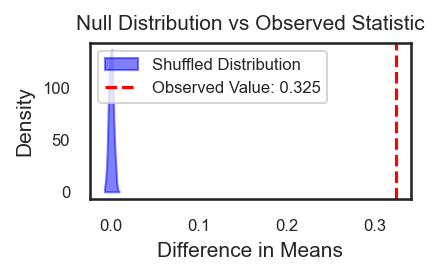

Observed Stat: 0.3252451077572438
P-Value: 0.000999000999000999


In [21]:
import numpy as np
import pickle
from tqdm import tqdm

def monte_carlo_randomization_combined(data_file, condition1, condition2, n_permutations=10000):
    """
    Monte Carlo randomization test for combined eye data.

    Args:
        data_file (str): Path to the exported aggregated data pickle file.
        condition1 (str): First condition (e.g., 'quiet').
        condition2 (str): Second condition (e.g., 'active').
        n_permutations (int): Number of random shuffles for the test.

    Returns:
        dict: Contains observed statistic, p-value, and null distribution.
    """
    # Load combined data
    with open(data_file, 'rb') as f:
        data = pickle.load(f)

    # Extract data for the two conditions
    data1 = np.array(data[condition1])
    data2 = np.array(data[condition2])

    # Calculate observed difference in means
    observed_stat = np.mean(data1) - np.mean(data2)

    # Combine all data and labels
    combined_data = np.concatenate((data1, data2))
    labels = np.array([1] * len(data1) + [0] * len(data2))

    # Null distribution from shuffled labels
    null_dist = []
    for _ in tqdm(range(n_permutations), desc="Shuffling iterations"):
        np.random.shuffle(labels)
        shuffled_data1 = combined_data[labels == 1]
        shuffled_data2 = combined_data[labels == 0]
        null_dist.append(np.mean(shuffled_data1) - np.mean(shuffled_data2))

    # Calculate p-value
    p_value = (np.sum(np.abs(null_dist) >= np.abs(observed_stat)) + 1) / (n_permutations + 1)

    # Return results
    return {
        "observed_stat": observed_stat,
        "p_value": p_value,
        "null_distribution": null_dist
    }


Exported plots and data to: Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_4\material\pupil_diameter_behavior_split_pv62\split_eye_pupil_diameter_behavior_2024_12_25_00_47_41


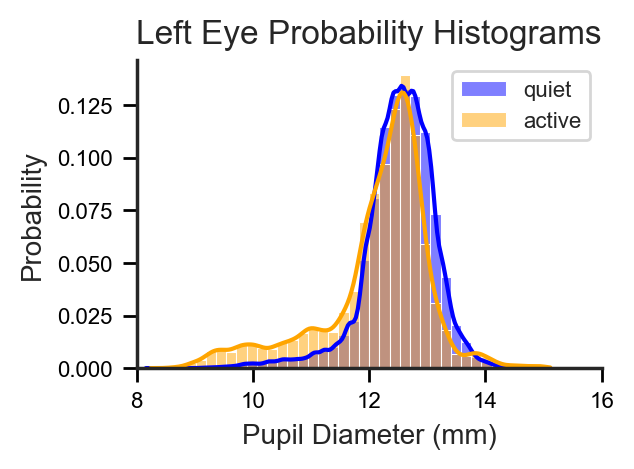

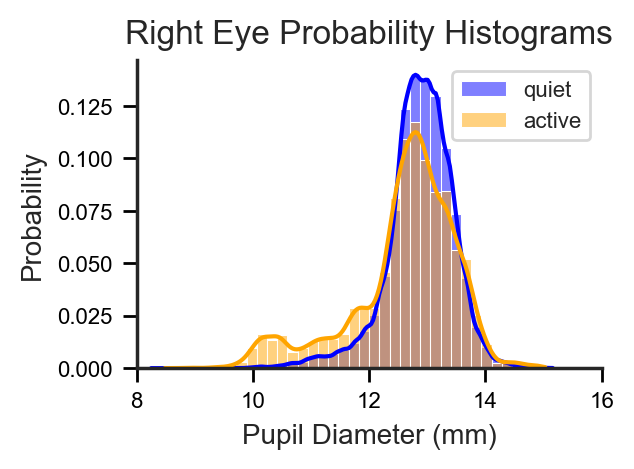

In [219]:
def plot_split_eye_probability_histograms(block_list, export_path=None, num_bins=50, x_range=(8, 15), outlier_percentiles=(0.001, 99.999)):
    """
    Generate and save Seaborn-based probability histograms for pupil diameter distributions
    across multiple blocks, with outlier removal and consistent bin widths. Separates data
    into two plots: one for the left eye and one for the right eye.

    Args:
        block_list: List of BlockSync objects with the following internal attributes:
            - behavior_df (pd.DataFrame): DataFrame with 'start_time', 'end_time', and 'annotation'.
            - left_eye_data (pd.DataFrame): DataFrame with 'ms_axis' and 'pupil_diameter' for the left eye.
            - right_eye_data (pd.DataFrame): DataFrame with 'ms_axis' and 'pupil_diameter' for the right eye.
        export_path (str): Path to save the output (folder created automatically if None is provided).
        num_bins (int): Number of bins to divide the pupil diameter values.
        x_range (tuple): Tuple specifying the x-axis range (min, max).
        outlier_percentiles (tuple): Percentile range to retain (e.g., (1, 99) keeps the central 98%).
    """
    # Initialize combined dictionaries for all blocks
    left_eye_aggregated = {}
    right_eye_aggregated = {}

    # Aggregate data and remove outliers
    all_data = []  # To calculate shared bin edges
    for block in block_list:
        behavior_df = block.behavior_state
        left_eye_data = block.left_eye_data
        right_eye_data = block.right_eye_data

        # Convert behavior_df times from seconds to milliseconds
        behavior_df['start_time_ms'] = behavior_df['start_time']
        behavior_df['end_time_ms'] = behavior_df['end_time']

        # Initialize aggregation for new annotations
        for label in behavior_df['annotation'].unique():
            if label not in left_eye_aggregated:
                left_eye_aggregated[label] = []
            if label not in right_eye_aggregated:
                right_eye_aggregated[label] = []

        # Aggregate data per annotation period
        for _, row in behavior_df.iterrows():
            start_time_ms = row['start_time_ms']
            end_time_ms = row['end_time_ms']
            annotation = row['annotation']

            # Get pupil diameters for the current annotation period
            left_eye_values = left_eye_data.query('ms_axis > @start_time_ms and ms_axis < @end_time_ms')['pupil_diameter'].dropna()
            right_eye_values = right_eye_data.query('ms_axis >= @start_time_ms and ms_axis <= @end_time_ms')['pupil_diameter'].dropna()

            # Add data to respective dictionaries
            left_eye_aggregated[annotation].extend(left_eye_values)
            right_eye_aggregated[annotation].extend(right_eye_values)

            # Collect all data for bin edge calculation
            all_data.extend(left_eye_values)
            all_data.extend(right_eye_values)

    # Determine shared bin edges
    outlier_min, outlier_max = np.percentile(all_data, outlier_percentiles)
    bin_edges = np.linspace(max(outlier_min, x_range[0]), min(outlier_max, x_range[1]), num_bins + 1)

    # Seaborn styling
    sns.set(style="white")
    color_map = {'quiet': 'blue', 'active': 'orange'}

    # Plot for left eye
    fig_left, ax_left = plt.subplots(figsize=(3, 2), dpi=200)
    for annotation, data in left_eye_aggregated.items():
        # Remove outliers
        filtered_data = [val for val in data if outlier_min <= val <= outlier_max]
        sns.histplot(
            filtered_data,
            bins=bin_edges,
            stat='probability',
            element='bars',
            label=f'{annotation}',
            alpha=0.5,
            color=color_map.get(annotation, 'gray'), kde=True,
            ax=ax_left,
        )
    ax_left.set_title('Left Eye Probability Histograms', fontsize=12)
    ax_left.set_xlabel('Pupil Diameter (mm)', fontsize=10)
    ax_left.set_ylabel('Probability', fontsize=10)
    ax_left.tick_params(axis='both', labelsize=8)
    ax_left.spines['right'].set_visible(False)
    ax_left.spines['top'].set_visible(False)
    ax_left.tick_params(axis='both', direction='out', which='major',length=5, width=1, colors='black', bottom=True, left=True)
    ax_left.tick_params(axis='both', direction='out', which='minor', length=5, width=1,colors='black', bottom=True, left=True)
    ax_left.set_xlim(x_range)
    ax_left.legend(loc='upper right', fontsize=8)

    # Plot for right eye
    fig_right, ax_right = plt.subplots(figsize=(3, 2), dpi=200)
    for annotation, data in right_eye_aggregated.items():
        # Remove outliers
        filtered_data = [val for val in data if outlier_min <= val <= outlier_max]
        sns.histplot(
            filtered_data,
            bins=bin_edges,
            stat='probability',
            element='bars',
            label=f'{annotation}',
            alpha=0.5,
            color=color_map.get(annotation, 'gray'),kde=True,
            ax=ax_right,
        )
    
    ax_right.set_title('Right Eye Probability Histograms', fontsize=12)
    ax_right.set_xlabel('Pupil Diameter (mm)', fontsize=10)
    ax_right.set_ylabel('Probability', fontsize=10)
    ax_right.tick_params(axis='both', labelsize=8)
    ax_right.spines['right'].set_visible(False)
    ax_right.spines['top'].set_visible(False)
    ax_right.tick_params(axis='both', direction='out', which='major',length=5, width=1, colors='black', bottom=True, left=True)
    ax_right.tick_params(axis='both', direction='out', which='minor', length=5, width=1,colors='black', bottom=True, left=True)
    ax_right.set_xlim(x_range)
    ax_right.legend(loc='upper right', fontsize=8)

    # Export section
    if export_path is not None:
        # Create timestamped folder
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"split_eye_pupil_diameter_behavior_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)

        # Save left eye plot
        pdf_file_left = os.path.join(full_export_path, "left_eye_pupil_vs_behavior.pdf")
        fig_left.savefig(pdf_file_left, format='pdf', bbox_inches='tight', dpi=300)

        # Save right eye plot
        pdf_file_right = os.path.join(full_export_path, "right_eye_pupil_vs_behavior.pdf")
        fig_right.savefig(pdf_file_right, format='pdf', bbox_inches='tight', dpi=300)

        # Save raw data
        data_file = os.path.join(full_export_path, "aggregated_data.pkl")
        with open(data_file, 'wb') as f:
            pickle.dump({'left_eye': left_eye_aggregated, 'right_eye': right_eye_aggregated}, f)

        print(f"Exported plots and data to: {full_export_path}")

    plt.show()
export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_4\material\pupil_diameter_behavior_split_pv62'
plot_split_eye_probability_histograms(block_collection, export_path=export_path, num_bins=40, x_range=(8, 16))

In [192]:
print(block.L_pix_size)

0.045


In [175]:
block.L_pix_size = 0.044

In [176]:
for block in block_collection:
    # calibrate pupil diameter:
    block.left_eye_data['pupil_diameter_pixels'] = block.left_eye_data.major_ax * 2 * np.pi
    block.right_eye_data['pupil_diameter_pixels'] = block.right_eye_data.major_ax * 2 * np.pi
    block.left_eye_data['pupil_diameter'] = block.left_eye_data['pupil_diameter_pixels'] * block.L_pix_size
    block.right_eye_data['pupil_diameter'] = block.right_eye_data['pupil_diameter_pixels'] * block.R_pix_size

In [178]:
internal_df = pd.DataFrame(columns=['L_pix_size', 'R_pix_size'])
internal_df.at[0, 'L_pix_size'] = block.L_pix_size
internal_df.at[0, 'R_pix_size'] = block.R_pix_size
internal_df.to_csv(block.analysis_path / 'LR_pix_size.csv', index=False)

In [10]:
print(block.L_pix_size,block.R_pix_size)

0.04227545705393053 0.04446860679524895


In [191]:
block.calibrate_pixel_size(10)

got the calibration values from the analysis folder


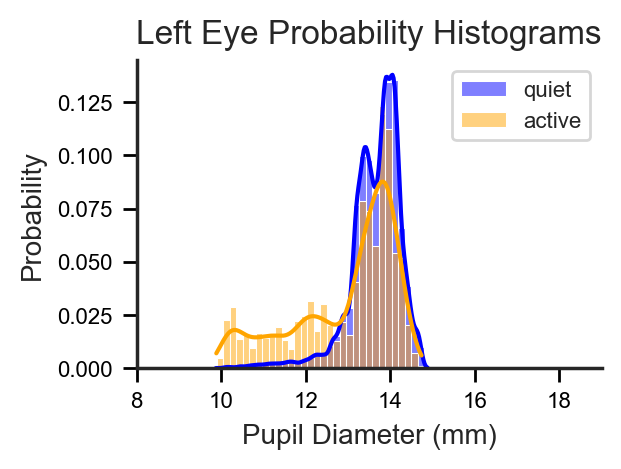

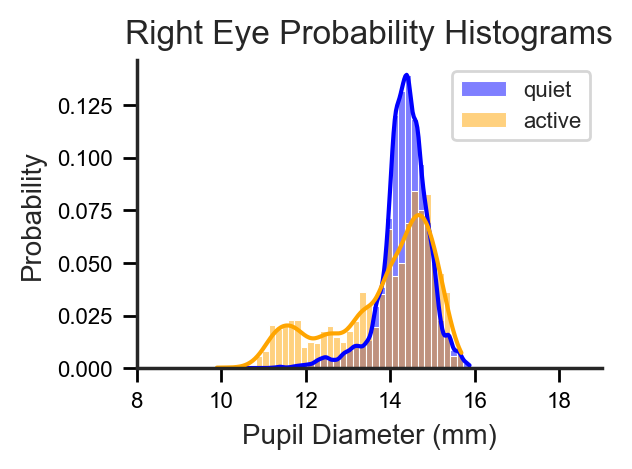

In [187]:
def plot_split_eye_probability_histograms(block_list, export_path=None, num_bins=50, x_range=(8, 15), outlier_percentiles=(0.001, 99.999)):
    """
    Generate and save Seaborn-based probability histograms for pupil diameter distributions
    across multiple blocks, with outlier removal and consistent bin widths. Separates data
    into two plots: one for the left eye and one for the right eye.

    Args:
        block_list: List of BlockSync objects with the following internal attributes:
            - behavior_df (pd.DataFrame): DataFrame with 'start_time', 'end_time', and 'annotation'.
            - left_eye_data (pd.DataFrame): DataFrame with 'ms_axis' and 'pupil_diameter' for the left eye.
            - right_eye_data (pd.DataFrame): DataFrame with 'ms_axis' and 'pupil_diameter' for the right eye.
        export_path (str): Path to save the output (folder created automatically if None is provided).
        num_bins (int): Number of bins to divide the pupil diameter values.
        x_range (tuple): Tuple specifying the x-axis range (min, max).
        outlier_percentiles (tuple): Percentile range to retain (e.g., (1, 99) keeps the central 98%).
    """
    # Initialize combined dictionaries for all blocks
    left_eye_aggregated = {}
    right_eye_aggregated = {}

    # Aggregate data and remove outliers
    all_data = []  # To calculate shared bin edges
    for block in block_list:
        behavior_df = block.behavior_state
        left_eye_data = block.left_eye_data
        right_eye_data = block.right_eye_data

        # Convert behavior_df times from seconds to milliseconds
        behavior_df['start_time_ms'] = behavior_df['start_time']
        behavior_df['end_time_ms'] = behavior_df['end_time']

        # Initialize aggregation for new annotations
        for label in behavior_df['annotation'].unique():
            if label not in left_eye_aggregated:
                left_eye_aggregated[label] = []
            if label not in right_eye_aggregated:
                right_eye_aggregated[label] = []

        # Aggregate data per annotation period
        for _, row in behavior_df.iterrows():
            start_time_ms = row['start_time_ms']
            end_time_ms = row['end_time_ms']
            annotation = row['annotation']

            # Get pupil diameters for the current annotation period
            left_eye_values = left_eye_data.query('ms_axis > @start_time_ms and ms_axis < @end_time_ms')['pupil_diameter'].dropna()
            right_eye_values = right_eye_data.query('ms_axis >= @start_time_ms and ms_axis <= @end_time_ms')['pupil_diameter'].dropna()

            # Add data to respective dictionaries
            left_eye_aggregated[annotation].extend(left_eye_values)
            right_eye_aggregated[annotation].extend(right_eye_values)

            # Collect all data for bin edge calculation
            all_data.extend(left_eye_values)
            all_data.extend(right_eye_values)

    # Determine shared bin edges
    outlier_min, outlier_max = np.percentile(all_data, outlier_percentiles)
    bin_edges = np.linspace(max(outlier_min, x_range[0]), min(outlier_max, x_range[1]), num_bins + 1)

    # Seaborn styling
    sns.set(style="white")
    color_map = {'quiet': 'blue', 'active': 'orange'}

    # Plot for left eye
    fig_left, ax_left = plt.subplots(figsize=(3, 2), dpi=200)
    for annotation, data in left_eye_aggregated.items():
        # Remove outliers
        filtered_data = [val for val in data if outlier_min <= val <= outlier_max]
        sns.histplot(
            filtered_data,
            bins=bin_edges,
            stat='probability',
            element='bars',
            label=f'{annotation}',
            alpha=0.5,
            color=color_map.get(annotation, 'gray'), kde=True,
            ax=ax_left,
        )
    ax_left.set_title('Left Eye Probability Histograms', fontsize=12)
    ax_left.set_xlabel('Pupil Diameter (mm)', fontsize=10)
    ax_left.set_ylabel('Probability', fontsize=10)
    ax_left.tick_params(axis='both', labelsize=8)
    ax_left.spines['right'].set_visible(False)
    ax_left.spines['top'].set_visible(False)
    ax_left.tick_params(axis='both', direction='out', which='major',length=5, width=1, colors='black', bottom=True, left=True)
    ax_left.tick_params(axis='both', direction='out', which='minor', length=5, width=1,colors='black', bottom=True, left=True)
    ax_left.set_xlim(x_range)
    ax_left.legend(loc='upper right', fontsize=8)

    # Plot for right eye
    fig_right, ax_right = plt.subplots(figsize=(3, 2), dpi=200)
    for annotation, data in right_eye_aggregated.items():
        # Remove outliers
        filtered_data = [val for val in data if outlier_min <= val <= outlier_max]
        sns.histplot(
            filtered_data,
            bins=bin_edges,
            stat='probability',
            element='bars',
            label=f'{annotation}',
            alpha=0.5,
            color=color_map.get(annotation, 'gray'),kde=True,
            ax=ax_right,
        )
    
    ax_right.set_title('Right Eye Probability Histograms', fontsize=12)
    ax_right.set_xlabel('Pupil Diameter (mm)', fontsize=10)
    ax_right.set_ylabel('Probability', fontsize=10)
    ax_right.tick_params(axis='both', labelsize=8)
    ax_right.spines['right'].set_visible(False)
    ax_right.spines['top'].set_visible(False)
    ax_right.tick_params(axis='both', direction='out', which='major',length=5, width=1, colors='black', bottom=True, left=True)
    ax_right.tick_params(axis='both', direction='out', which='minor', length=5, width=1,colors='black', bottom=True, left=True)
    ax_right.set_xlim(x_range)
    ax_right.legend(loc='upper right', fontsize=8)

    # Export section
    if export_path is not None:
        # Create timestamped folder
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"split_eye_pupil_diameter_behavior_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)

        # Save left eye plot
        pdf_file_left = os.path.join(full_export_path, "left_eye_pupil_vs_behavior.pdf")
        fig_left.savefig(pdf_file_left, format='pdf', bbox_inches='tight', dpi=300)

        # Save right eye plot
        pdf_file_right = os.path.join(full_export_path, "right_eye_pupil_vs_behavior.pdf")
        fig_right.savefig(pdf_file_right, format='pdf', bbox_inches='tight', dpi=300)

        # Save raw data
        data_file = os.path.join(full_export_path, "aggregated_data.pkl")
        with open(data_file, 'wb') as f:
            pickle.dump({'left_eye': left_eye_aggregated, 'right_eye': right_eye_aggregated}, f)

        print(f"Exported plots and data to: {full_export_path}")

    plt.show()
export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_4\material\pupil_diameter_behavior_split_pv62'
plot_split_eye_probability_histograms(block_collection, export_path=None, num_bins=40, x_range=(8, 19))

In [ ]:
#older versionss

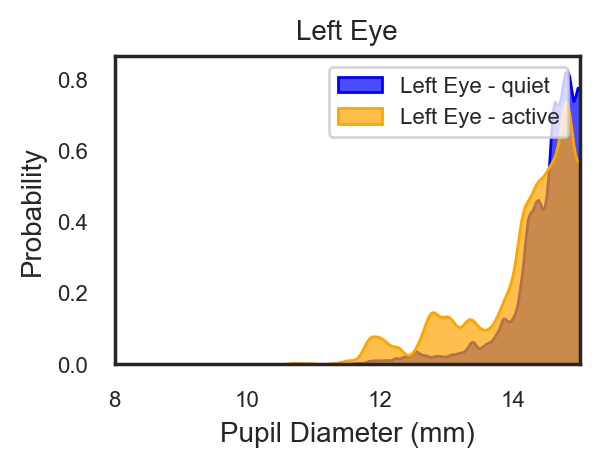

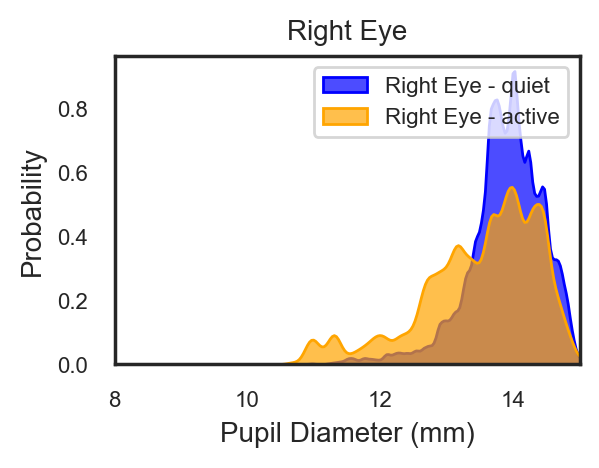

In [165]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np

def aggregate_and_plot_probabilities_multi_blocks(block_list, export_path=None, num_bins=50):
    """
    Generate and save elegant Seaborn-based probability plots for pupil diameter distributions
    across multiple blocks.

    Args:
        block_list: List of BlockSync objects with the following internal attributes:
            - behavior_df (pd.DataFrame): DataFrame with 'start_time', 'end_time', and 'annotation'.
            - left_eye_data (pd.DataFrame): DataFrame with 'ms_axis' and 'pupil_diameter' for the left eye.
            - right_eye_data (pd.DataFrame): DataFrame with 'ms_axis' and 'pupil_diameter' for the right eye.
        export_path (str): Path to save the PDF containing the plots (optional).
        num_bins (int): Number of bins to divide the pupil diameter values.
    """
    # Initialize combined dictionaries for all blocks
    left_eye_aggregated = {}
    right_eye_aggregated = {}
    
    # Loop through each block to aggregate data
    for block in block_list:
        behavior_df = block.behavior_state
        left_eye_data = block.left_eye_data
        right_eye_data = block.right_eye_data

        # Convert behavior_df times from seconds to milliseconds
        behavior_df['start_time_ms'] = behavior_df['start_time']
        behavior_df['end_time_ms'] = behavior_df['end_time']

        # Initialize aggregation for new annotations
        for label in behavior_df['annotation'].unique():
            if label not in left_eye_aggregated:
                left_eye_aggregated[label] = []
            if label not in right_eye_aggregated:
                right_eye_aggregated[label] = []

        # Aggregate data per annotation period
        for _, row in behavior_df.iterrows():
            start_time_ms = row['start_time_ms']
            end_time_ms = row['end_time_ms']
            annotation = row['annotation']
            
            # Get pupil diameters for the current annotation period
            left_eye_values = left_eye_data.query('ms_axis > @start_time_ms and ms_axis < @end_time_ms')['pupil_diameter'].dropna()
            right_eye_values = right_eye_data.query('(ms_axis >= @start_time_ms) and (ms_axis <= @end_time_ms)')['pupil_diameter'].dropna()
            
            left_eye_aggregated[annotation].extend(left_eye_values)
            right_eye_aggregated[annotation].extend(right_eye_values)

    # Prepare to save both figures to the same PDF
    if export_path is not None:
        pdf_pages = PdfPages(export_path)

    # Seaborn styling
    sns.set(style="white")
    color_map = {'quiet': 'blue', 'active': 'orange'}

    # Plot probabilities for the left eye
    plt.figure(figsize=(3, 2), dpi=200)
    for annotation, data in left_eye_aggregated.items():
        # sns.histplot(data, bins=num_bins, stat='probability', element='poly', kde=True,
        #              label=f'Left Eye - {annotation}', alpha=0.7,
        #              color=color_map.get(annotation, 'gray'), fill=False)
        sns.kdeplot(
        data,
        label=f'Left Eye - {annotation}',
        alpha=0.7,
        color=color_map.get(annotation, 'gray'),
        bw_adjust=0.5,  # Adjust bandwidth if needed
        fill=True,
        common_norm=False)  # Ensures each annotation's curve integrates to 1
    plt.title('Left Eye', fontsize=10)
    plt.xlabel('Pupil Diameter (mm)', fontsize=10)
    plt.ylabel('Probability', fontsize=10)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.xlim(8,15)
    plt.legend(loc='upper right', fontsize=8)
    if export_path is not None:
        pdf_pages.savefig()
    plt.show()

    # Plot probabilities for the right eye
    plt.figure(figsize=(3, 2), dpi=200)
    for annotation, data in right_eye_aggregated.items():
        # sns.histplot(data, bins=num_bins, stat='probability', element='poly', kde=True,
        #              label=f'Right Eye - {annotation}', alpha=0.7,
        #              color=color_map.get(annotation, 'gray'), fill=False)
        
        sns.kdeplot(
            data,
            label=f'Right Eye - {annotation}',
            alpha=0.7,
            color=color_map.get(annotation, 'gray'),
            bw_adjust=0.5,  # Adjust bandwidth if needed
            fill=True,
            common_norm=False  # Ensures each annotation's curve integrates to 1
        )
    plt.title('Right Eye', fontsize=10)
    plt.xlabel('Pupil Diameter (mm)', fontsize=10)
    plt.ylabel('Probability', fontsize=10)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.xlim(8,15)
    plt.legend(loc='upper right', fontsize=8)
    if export_path is not None:
        pdf_pages.savefig()

    if export_path is not None:
        pdf_pages.close()

    plt.show()
aggregate_and_plot_probabilities_multi_blocks(block_collection, export_path=None)

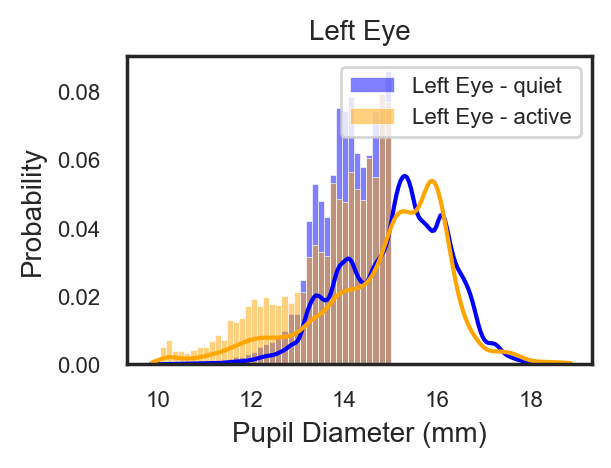

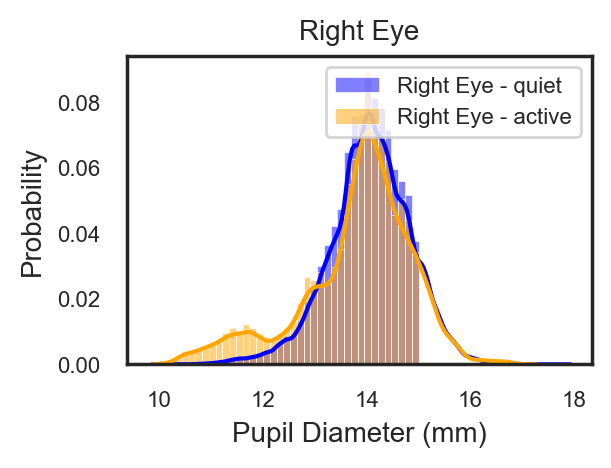

In [145]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np

def plot_probability_histograms(block_list, export_path=None, num_bins=50, x_range=(8, 15), outlier_percentiles=(0.001, 99.999)):
    """
    Generate and save Seaborn-based probability histograms for pupil diameter distributions
    across multiple blocks, with outlier removal and consistent bin widths.

    Args:
        block_list: List of BlockSync objects with the following internal attributes:
            - behavior_df (pd.DataFrame): DataFrame with 'start_time', 'end_time', and 'annotation'.
            - left_eye_data (pd.DataFrame): DataFrame with 'ms_axis' and 'pupil_diameter' for the left eye.
            - right_eye_data (pd.DataFrame): DataFrame with 'ms_axis' and 'pupil_diameter' for the right eye.
        export_path (str): Path to save the PDF containing the plots (optional).
        num_bins (int): Number of bins to divide the pupil diameter values.
        x_range (tuple): Tuple specifying the x-axis range (min, max).
        outlier_percentiles (tuple): Percentile range to retain (e.g., (1, 99) keeps the central 98%).
    """
    # Initialize combined dictionaries for all blocks
    left_eye_aggregated = {}
    right_eye_aggregated = {}

    # Aggregate data and remove outliers
    all_data = []  # To calculate shared bin edges
    for block in block_list:
        behavior_df = block.behavior_state
        left_eye_data = block.left_eye_data
        right_eye_data = block.right_eye_data

        # Convert behavior_df times from seconds to milliseconds
        behavior_df['start_time_ms'] = behavior_df['start_time']
        behavior_df['end_time_ms'] = behavior_df['end_time']

        # Initialize aggregation for new annotations
        for label in behavior_df['annotation'].unique():
            if label not in left_eye_aggregated:
                left_eye_aggregated[label] = []
            if label not in right_eye_aggregated:
                right_eye_aggregated[label] = []

        # Aggregate data per annotation period
        for _, row in behavior_df.iterrows():
            start_time_ms = row['start_time_ms']
            end_time_ms = row['end_time_ms']
            annotation = row['annotation']

            # Get pupil diameters for the current annotation period
            left_eye_values = left_eye_data.query('ms_axis > @start_time_ms and ms_axis < @end_time_ms')['pupil_diameter'].dropna()
            right_eye_values = right_eye_data.query('ms_axis >= @start_time_ms and ms_axis <= @end_time_ms')['pupil_diameter'].dropna()

            # Add to aggregated dictionaries
            left_eye_aggregated[annotation].extend(left_eye_values)
            right_eye_aggregated[annotation].extend(right_eye_values)

            # Collect all data for bin edge calculation
            all_data.extend(left_eye_values)
            all_data.extend(right_eye_values)

    # Determine shared bin edges
    outlier_min, outlier_max = np.percentile(all_data, outlier_percentiles)
    bin_edges = np.linspace(max(outlier_min, x_range[0]), min(outlier_max, x_range[1]), num_bins + 1)

    # Prepare to save both figures to the same PDF
    if export_path is not None:
        pdf_pages = PdfPages(export_path)

    # Seaborn styling
    sns.set(style="white")
    color_map = {'quiet': 'blue', 'active': 'orange'}

    # Plot probabilities for the left eye
    plt.figure(figsize=(3, 2), dpi=200)
    for annotation, data in left_eye_aggregated.items():
        # Remove outliers
        filtered_data = [val for val in data if outlier_min <= val <= outlier_max]
        sns.histplot(
            filtered_data,
            bins=bin_edges,
            stat='probability',  # Normalize bin heights to sum to 1
            element='bars',
            label=f'Left Eye - {annotation}',
            alpha=0.5,
            color=color_map.get(annotation, 'gray'),kde=True
        )
    plt.title('Left Eye', fontsize=10)
    plt.xlabel('Pupil Diameter (mm)', fontsize=10)
    plt.ylabel('Probability', fontsize=10)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    #plt.xlim(x_range)
    plt.legend(loc='upper right', fontsize=8)
    if export_path is not None:
        pdf_pages.savefig()
    plt.show()

    # Plot probabilities for the right eye
    plt.figure(figsize=(3, 2), dpi=200)
    for annotation, data in right_eye_aggregated.items():
        # Remove outliers
        filtered_data = [val for val in data if outlier_min <= val <= outlier_max]
        sns.histplot(
            filtered_data,
            bins=bin_edges,
            stat='probability',  # Normalize bin heights to sum to 1
            element='bars',
            label=f'Right Eye - {annotation}',
            alpha=0.5,
            color=color_map.get(annotation, 'gray'),kde=True
        )
    plt.title('Right Eye', fontsize=10)
    plt.xlabel('Pupil Diameter (mm)', fontsize=10)
    plt.ylabel('Probability', fontsize=10)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    #plt.xlim(x_range)
    plt.legend(loc='upper right', fontsize=8)
    if export_path is not None:
        pdf_pages.savefig()

    if export_path is not None:
        pdf_pages.close()

    plt.show()
plot_probability_histograms(block_collection, export_path=None, num_bins=40, x_range=(8, 15))

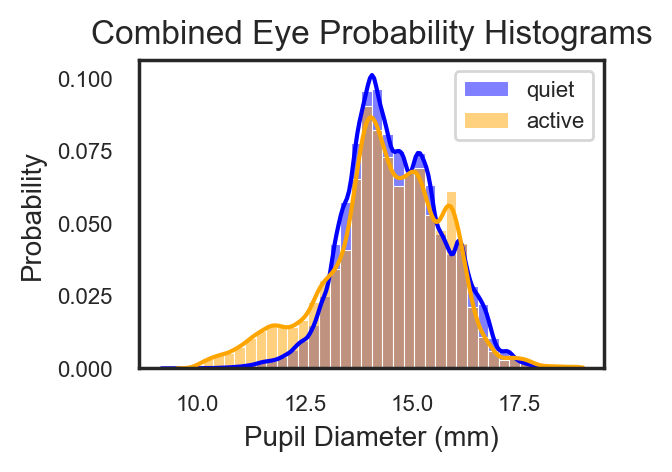

In [146]:
def plot_combined_eye_probability_histograms(block_list, export_path=None, num_bins=50, x_range=(8, 15), outlier_percentiles=(0.0001, 99.9999)):
    """
    Generate and save Seaborn-based probability histograms for pupil diameter distributions
    across multiple blocks, with outlier removal and consistent bin widths. Combines left and right eye
    data for each annotation into a single curve.

    Args:
        block_list: List of BlockSync objects with the following internal attributes:
            - behavior_df (pd.DataFrame): DataFrame with 'start_time', 'end_time', and 'annotation'.
            - left_eye_data (pd.DataFrame): DataFrame with 'ms_axis' and 'pupil_diameter' for the left eye.
            - right_eye_data (pd.DataFrame): DataFrame with 'ms_axis' and 'pupil_diameter' for the right eye.
        export_path (str): Path to save the PDF containing the plots (optional).
        num_bins (int): Number of bins to divide the pupil diameter values.
        x_range (tuple): Tuple specifying the x-axis range (min, max).
        outlier_percentiles (tuple): Percentile range to retain (e.g., (1, 99) keeps the central 98%).
    """
    # Initialize combined dictionaries for all blocks
    combined_aggregated = {}

    # Aggregate data and remove outliers
    all_data = []  # To calculate shared bin edges
    for block in block_list:
        behavior_df = block.behavior_state
        left_eye_data = block.left_eye_data
        right_eye_data = block.right_eye_data

        # Convert behavior_df times from seconds to milliseconds
        behavior_df['start_time_ms'] = behavior_df['start_time']
        behavior_df['end_time_ms'] = behavior_df['end_time']

        # Initialize aggregation for new annotations
        for label in behavior_df['annotation'].unique():
            if label not in combined_aggregated:
                combined_aggregated[label] = []

        # Aggregate data per annotation period
        for _, row in behavior_df.iterrows():
            start_time_ms = row['start_time_ms']
            end_time_ms = row['end_time_ms']
            annotation = row['annotation']

            # Get pupil diameters for the current annotation period
            left_eye_values = left_eye_data.query('ms_axis > @start_time_ms and ms_axis < @end_time_ms')['pupil_diameter'].dropna()
            right_eye_values = right_eye_data.query('ms_axis >= @start_time_ms and ms_axis <= @end_time_ms')['pupil_diameter'].dropna()

            # Combine data from both eyes
            combined_aggregated[annotation].extend(left_eye_values)
            combined_aggregated[annotation].extend(right_eye_values)

            # Collect all data for bin edge calculation
            all_data.extend(left_eye_values)
            all_data.extend(right_eye_values)

    # Determine shared bin edges
    outlier_min, outlier_max = np.percentile(all_data, outlier_percentiles)
    bin_edges = np.linspace(max(outlier_min, x_range[0]), min(outlier_max, x_range[1]), num_bins + 1)

    # Prepare to save figure to a PDF if needed
    if export_path is not None:
        pdf_pages = PdfPages(export_path)

    # Seaborn styling
    sns.set(style="white")
    color_map = {'quiet': 'blue', 'active': 'orange'}

    # Plot combined data for all annotations
    plt.figure(figsize=(3, 2), dpi=200)
    for annotation, data in combined_aggregated.items():
        # Remove outliers
        filtered_data = [val for val in data if outlier_min <= val <= outlier_max]
        sns.histplot(
            filtered_data,
            bins=bin_edges,
            stat='probability',
            element='bars',
            label=f'{annotation}',
            alpha=0.5,
            color=color_map.get(annotation, 'gray'),kde=True
        )

    plt.title('Combined Eye Probability Histograms', fontsize=12)
    plt.xlabel('Pupil Diameter (mm)', fontsize=10)
    plt.ylabel('Probability', fontsize=10)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    #plt.xlim(x_range)
    plt.legend(loc='upper right', fontsize=8)
    if export_path is not None:
        pdf_pages.savefig()

    if export_path is not None:
        pdf_pages.close()

    plt.show()

plot_combined_eye_probability_histograms(block_collection, export_path=None, num_bins=40, x_range=(0, 50))

In [223]:
cumulative_length = 0
for block in block_collection:
    cumulative_length+= len(block.left_eye_data) // 60 

In [226]:
cumulative_length // 60 // 60

2